# Transformer Model: PyTorch Implementation

---

This Colab notebook presents a detailed implementation of the Transformer model using PyTorch.

## Key Features:

1. **Dataset**: The model is trained on 100,000 sentences from the opus books dataset (English to French translations).
   
2. **Implementation Details**: The Transformer is built from scratch, delving deep into multi-head attention, positional encodings, and normalization techniques.

3. **Neural Network Insights**: This notebook elaborates on various neural network concepts, optimization techniques, and evaluation metrics including BLEU, METEOR, and ROUGE.

4. **Evaluation**: We rigorously benchmark the model's performance using standard NLP metrics.

## Note:
While the notebook contains experimentations that might be non-critical to the main flow, it is primarily designed for personal use, offering a comprehensive understanding of the Transformer's workings. It's shared publicly in the hope that other enthusiasts and researchers might find it beneficial.

---

# Model

In [12]:
import torch
import torch.nn as nn
import math

class InputEmbeddings(nn.Module):
    """
    Embedding layer used in the Transformer model.
    Scales the embeddings by the square root of the embedding dimension.
    """
    def __init__(self, embed_size: int, vocab_size: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.scale = math.sqrt(embed_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the embedding layer.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch, seq_len).

        Returns:
        - torch.Tensor: Embedded and scaled tensor of shape (batch, seq_len, d_model).
        """
        return self.embedding(x) * self.scale

class PositionalEncoding(nn.Module):
    """
    Implements the sinusoidal positional encoding for non-recurrent neural networks.

    The positional encoding is necessary to give the model some information about
    the relative position of the words in the sentence. This class generates a
    matrix of sinusoids where each row corresponds to a position in the sentence
    and can be added to word embeddings.

    Args:
        embed_size (int): Size of the word embeddings.
        max_len (int): Maximum length of sequences that will be passed through the model.
        dropout (float): Dropout rate for the dropout layer applied to the sum of embeddings and positional encodings.
        base (float, optional): Base of the logarithm used in the positional encoding. Default is 10000.

    Attributes:
        dropout (nn.Module): Dropout layer.
        pe (torch.Tensor): Positional encoding matrix.
    """
    def __init__(self, embed_size: int, max_len: int, dropout: float, base: float = 10000.0) -> None:
        super().__init__()

        assert embed_size % 2 == 0, "Embedding dimension must be even to use this positional encoding method."

        self.dropout = nn.Dropout(dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, embed_size)

        # Create a position vector
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Create a term for the division inside the sine and cosine functions
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(base) / embed_size))

        # Apply the positional encoding formula
        pe[:, 0::2] = torch.sin(position * div_term)  # sine applied to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # cosine applied to odd indices

        pe = pe.unsqueeze(0)  # Add a batch dimension for broadcasting
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Adds positional encodings to token embeddings.

        Args:
            x (torch.Tensor): Token embeddings. Shape: (batch_size, sequence_length, embed_size)

        Returns:
            torch.Tensor: Token embeddings with added positional encodings, with dropout applied. Shape: (batch_size, sequence_length, embed_size)
        """
        x = x + self.pe[:, :x.size(1)]
        # x = x + (self.pe[:, :x.shape[1], :])
        return self.dropout(x)

class LayerNormalization(nn.Module):
    """
    Implements Layer Normalization, a type of normalization technique.
    The normalization is performed over the last dimension of the input tensor.

    Attributes:
        eps (float): A small value to ensure numerical stability (prevent division by zero).
        gamma (nn.Parameter): A learnable scale factor. Initialized with ones.
        beta (nn.Parameter): A learnable shift (bias). Initialized with zeros.
    """

    def __init__(self, embed_size: int, eps: float = 1e-6) -> None:
        """
        Args:
            embed_size (int): The size of the last dimension of the input tensor.
            eps (float, optional): A small value for numerical stability. Defaults to 1e-6.
        """
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(embed_size))  # gamma is a learnable parameter
        self.beta = nn.Parameter(torch.zeros(embed_size))  # beta is a learnable parameter

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply layer normalization over the last dimension of the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, seq_len, embed_size).

        Returns:
            torch.Tensor: Normalized tensor of the same shape as the input.
        """

        # Calculate mean and standard deviation
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)


        # print("LayerNorm mean:", mean)
        # print("LayerNorm std:", std)
        # print("LayerNorm output:", self.gamma * (x - mean) / (std + self.eps) + self.beta)


        # Apply layer normalization
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class FeedForwardBlock(nn.Module):
    def __init__(self, embed_size: int, d_ff: int, dropout: float, activation_fn: nn.Module = nn.ReLU()) -> None:
        """
        Initializes the FeedForwardBlock.

        Args:
        - embed_size (int): Dimensionality of the input.
        - d_ff (int): Dimensionality of the hidden layer.
        - dropout (float): Dropout rate.
        - activation_fn (nn.Module): Activation function to use. Default is ReLU.
        """
        super().__init__()

        self.input_layer = nn.Linear(embed_size, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(d_ff, embed_size)
        self.activation_fn = activation_fn

    def forward(self, x):
        """
        Forward pass for the FeedForwardBlock.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch, seq_len, embed_size)

        Returns:
        - torch.Tensor: Output tensor of shape (batch, seq_len, embed_size)
        """
        # return self.output_layer(self.dropout(self.activation_fn(self.input_layer(x))))
        # Print input and output values
        # print("FeedForward input:", x)
        output = self.output_layer(self.dropout(self.activation_fn(self.input_layer(x))))
        # print("FeedForward output:", output)

        return output


class MultiHeadAttentionBlock(nn.Module):
    """
    Implements a Multi-Head Attention mechanism, as described in the Transformer architecture.

    The multi-head attention mechanism allows the model to focus on different parts
    of the input for different tasks simultaneously, which can lead to more
    expressive representations.

    Attributes:
    - embed_size: The size of the embeddings (or the model dimension).
    - h: The number of attention heads.
    - head_dim: The dimension of each attention head.
    - w_q, w_k, w_v, w_o: Linear layers for query, key, value, and output respectively.
    - dropout: Dropout layer used after the attention mechanism.
    """

    def __init__(self, embed_size: int, h: int, dropout: float) -> None:
        """
        Initialize the MultiHeadAttentionBlock.

        Parameters:
        - embed_size: The size of the embeddings (or the model dimension).
        - h: Number of attention heads.
        - dropout: Dropout rate for the attention weights.
        """
        super().__init__()
        self.embed_size = embed_size
        self.h = h  # Number of heads

        # Ensure that the embedding size is divisible by the number of heads
        assert embed_size % h == 0, "embed_size must be divisible by the number of heads"

        self.head_dim = embed_size // h  # Dimension of each head

        # Define linear layers for query, key, value, and output projection
        self.w_q = nn.Linear(embed_size, embed_size, bias=False)
        self.w_k = nn.Linear(embed_size, embed_size, bias=False)
        self.w_v = nn.Linear(embed_size, embed_size, bias=False)
        self.w_o = nn.Linear(embed_size, embed_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        """
        Compute the attention weights and apply them to the values.

        Parameters:
        - query: The query tensor.
        - key: The key tensor.
        - value: The value tensor.
        - mask: A mask tensor to mask out certain values (e.g., padding).
        - dropout: Dropout layer to apply to the attention weights.

        Returns:
        - Tensor after applying attention mechanism.
        """
        d_k = query.shape[-1]

        # Compute attention scores
        # scores size: (batch_size, num_heads, seq_len, seq_len)
        scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

        # print("Attention scores:", scores)

        batch_size, num_heads, seq_len, _ = scores.shape


        # print("scores shape", scores.shape)
        # print("Initial mask shape:", mask.shape)
        if mask is not None:
            # Add heads dimension if it doesn't exist
            if len(mask.shape) == 3:
                mask = mask.unsqueeze(1)

            # Expand mask to match scores shape
            mask = mask.expand_as(scores)

            scores.masked_fill_(mask == 0, -1e9)


        # print("scores.masked_fill_: ", scores)






        # Normalize scores to attention weights
        # attention_weights size: (batch_size, num_heads, seq_len, seq_len)
        attention_weights = scores.softmax(dim=-1)

        # print("attention_weights:", attention_weights)

        if dropout is not None:
            attention_weights = dropout(attention_weights)

        # Apply attention weights to values
        # output size: (batch_size, num_heads, seq_len, d_k)
        return attention_weights @ value


    def forward(self, q, k, v, mask):
        """
        Forward pass for the MultiHeadAttentionBlock.

        Parameters:
        - q: The query tensor.
        - k: The key tensor.
        - v: The value tensor.
        - mask: A mask tensor to mask out certain values.

        Returns:
        - Output tensor after multi-head attention mechanism.
        """
        batch_size = q.shape[0]

        q = self.w_q(q)
        k = self.w_k(k)
        v = self.w_v(v)

        # Split the last dimension into (self.h, self.head_dim)
        # Then transpose it to shape (batch_size, self.h, sequence_length, self.head_dim)
        q = q.view(batch_size, -1, self.h, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, -1, self.h, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, -1, self.h, self.head_dim).transpose(1, 2)

        # Calculate attention
        x = self.attention(q, k, v, mask, self.dropout)

        # Concatenate heads and pass through the final linear layer
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_size)
        return self.w_o(x)

class ResidualConnection(nn.Module):
    """
    Implements a residual connection followed by a layer normalization.

    This module is used in Transformer blocks to ensure the gradients can flow through the network.
    The input is added to the result of the sub-layer function (which is first normalized and dropout is applied).
    """

    def __init__(self, embed_size: int, dropout: float) -> None:
        """
        Initialize the ResidualConnection module.

        Parameters:
        - embed_size: The size of the embeddings (or the model dimension).
        - dropout (float): The dropout rate.
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(embed_size=embed_size)

    def forward(self, x, sublayer):
        """
        Forward pass for the residual connection.

        Parameters:
        - x (torch.Tensor): The input tensor.
        - sublayer (callable): The sub-layer function (e.g., self-attention, feed-forward neural network).

        Returns:
        - torch.Tensor: The output tensor after applying the residual connection.
        """
        # Normalize the input and apply the sub-layer transformation
        sublayer_output = sublayer(self.norm(x))
        # Add the input to the sub-layer output (Residual Connection)
        return x + self.dropout(sublayer_output)

class EncoderBlock(nn.Module):
    """
    Defines a single block of the encoder containing a multi-head self-attention mechanism and a feed-forward neural network.
    Each of these sub-layers has a residual connection around it followed by layer normalization.
    """

    def __init__(self, embed_size: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        """
        Args:
            embed_size: The size of the embeddings (or the model dimension).
            self_attention_block (MultiHeadAttentionBlock): The multi-head self-attention mechanism.
            feed_forward_block (FeedForwardBlock): Point-wise feed-forward network.
            dropout (float): Dropout rate for residual connections.
        """
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(embed_size, dropout) for _ in range(2)])

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the encoder block.

        Args:
            src (torch.Tensor): Source input tensor.
            src_mask (torch.Tensor): Source mask tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the encoder block.
        """
        src = self.residual_connections[0](src, lambda src: self.self_attention_block(src, src, src, src_mask))
        src = self.residual_connections[1](src, self.feed_forward_block)
        return src



class Encoder(nn.Module):
    """
    The Encoder consists of a stack of several encoder blocks.
    After passing through all the encoder blocks, the output is normalized.
    """

    def __init__(self, embed_size: int, layers: nn.ModuleList) -> None:
        """
        Args:
            embed_size (int): The size of the embedding vectors.
            layers (nn.ModuleList): A list of encoder blocks.
        """
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(embed_size)

    def forward(self, src: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the encoder.

        Args:
            src (torch.Tensor): Source input tensor.
            mask (torch.Tensor): Source mask tensor.

        Returns:
            torch.Tensor: Output tensor after passing through all encoder blocks and normalization.
        """
        for layer in self.layers:
            src = layer(src, mask)
        return self.norm(src)

class DecoderBlock(nn.Module):
    """
    Defines a single block of the decoder containing two multi-head attention mechanisms
    (self-attention and cross-attention) followed by a feed-forward neural network.
    Each of these sub-layers has a residual connection around it followed by layer normalization.
    """

    def __init__(self, embed_size: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        """
        Args:
            embed_size: The size of the embeddings (or the model dimension).
            self_attention_block (MultiHeadAttentionBlock): The self-attention mechanism.
            cross_attention_block (MultiHeadAttentionBlock): The cross-attention mechanism.
            feed_forward_block (FeedForwardBlock): Point-wise feed-forward network.
            dropout (float): Dropout rate for residual connections.
        """
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(embed_size, dropout) for _ in range(3)])

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt_mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the decoder block.

        Args:
            x (torch.Tensor): Decoder input tensor.
            encoder_output (torch.Tensor): Encoder's output tensor.
            src_mask (torch.Tensor): Source mask tensor.
            tgt_mask (torch.Tensor): Target mask tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the decoder block.
        """
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

class Decoder(nn.Module):
    """
    The Decoder consists of a stack of several decoder blocks.
    After passing through all the decoder blocks, the output is normalized.
    """

    def __init__(self, embed_size: int, layers: nn.ModuleList) -> None:
        """
        Args:
            embed_size: The size of the embeddings (or the model dimension).
            layers (nn.ModuleList): A list of decoder blocks.
        """
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(embed_size)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt_mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the decoder.

        Args:
            x (torch.Tensor): Decoder input tensor.
            encoder_output (torch.Tensor): Encoder's output tensor.
            src_mask (torch.Tensor): Source mask tensor.
            tgt_mask (torch.Tensor): Target mask tensor.

        Returns:
            torch.Tensor: Output tensor after passing through all decoder blocks and normalization.
        """
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

class OutputLayer(nn.Module):
    """
    Implements the final linear layer that projects the transformer's output
    to a probability distribution over the vocabulary.

    Attributes:
        proj (nn.Linear): Linear layer that projects from d_model to vocab_size.
    """

    def __init__(self, embed_size: int, vocab_size: int) -> None:
        """
        Args:
            embed_size (int): The size of the embeddings (or the model dimension).
            vocab_size (int): Size of the vocabulary.
        """
        super().__init__()
        self.proj = nn.Linear(embed_size, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the output layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, seq_len, d_model).

        Returns:
            torch.Tensor: Output tensor of shape (batch, seq_len, vocab_size)
                          with log probabilities over the vocabulary.
        """
        # (batch, seq_len, embed_size) --> (batch, seq_len, vocab_size)
        return torch.log_softmax(self.proj(x), dim=-1)

class Transformer(nn.Module):
    """
    Implements the Transformer architecture combining encoder, decoder, embeddings, and a final projection layer.
    """

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings,
                 src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, output_layer: OutputLayer) -> None:
        """
        Args:
            encoder (Encoder): The encoder module.
            decoder (Decoder): The decoder module.
            src_embed (InputEmbeddings): Source embeddings layer.
            tgt_embed (InputEmbeddings): Target embeddings layer.
            src_pos (PositionalEncoding): Source positional encoding layer.
            tgt_pos (PositionalEncoding): Target positional encoding layer.
            output_layer (OutputLayer): Final output layer mapping to vocabulary size.
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.output_layer = output_layer

    def encode(self, src, src_mask):
        """
        Applies embeddings and positional encoding to the source, then passes it through the encoder.

        Args:
            src (torch.Tensor): Source sequence tensor.
            src_mask (torch.Tensor): Source sequence mask tensor.

        Returns:
            torch.Tensor: Encoder output tensor.
        """
        embedded_src = self.src_embed(src)  # Get the embeddings first
        src = embedded_src + self.src_pos(embedded_src)  # Then, add positional encodings to the embeddings
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        """
        Applies embeddings and positional encoding to the target, then passes it and the encoder output through the decoder.

        Args:
            encoder_output (torch.Tensor): Output tensor from the encoder.
            src_mask (torch.Tensor): Source sequence mask tensor.
            tgt (torch.Tensor): Target sequence tensor.
            tgt_mask (torch.Tensor): Target sequence mask tensor.

        Returns:
            torch.Tensor: Decoder output tensor.
        """
        embedded_tgt = self.tgt_embed(tgt)  # Get the embeddings first
        tgt = embedded_tgt + self.tgt_pos(embedded_tgt)  # Then, add positional encodings to the embeddings
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)


    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: torch.Tensor, tgt_mask: torch.Tensor):
        """
        End-to-end forward pass for the Transformer.

        Args:
            src (torch.Tensor): Source sequence tensor.
            tgt (torch.Tensor): Target sequence tensor.
            src_mask (torch.Tensor): Source sequence mask tensor.
            tgt_mask (torch.Tensor): Target sequence mask tensor.

        Returns:
            torch.Tensor: Projected output tensor.
        """
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(encoder_output, src_mask, tgt, tgt_mask)
        return self.output_layer(decoder_output)

def build_transformer(src_vocab_size: int, tgt_vocab_size: int, max_seq_len: int, embed_size: int=512, N: int=1, h: int=4, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    """
    Constructs and initializes a Transformer model.

    Args:
        src_vocab_size (int): Vocabulary size of the source language.
        tgt_vocab_size (int): Vocabulary size of the target language.
        max_seq_len (int): Maximum sequence length for the source language.
        embed_size (int): Dimension of embeddings and model. Defaults to 512.
        N (int): Number of blocks in both the encoder and decoder. Defaults to 1.
        h (int): Number of attention heads. Defaults to 4.
        dropout (float): Dropout rate for residual connections. Defaults to 0.1.
        d_ff (int): Dimension of the feed-forward network inside blocks. Defaults to 2048.

    Returns:
        Transformer: An initialized Transformer model.
    """
    # Create the embedding layers
    src_embed = InputEmbeddings(embed_size, src_vocab_size)
    tgt_embed = InputEmbeddings(embed_size, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(embed_size, max_seq_len, dropout)
    tgt_pos = PositionalEncoding(embed_size, max_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(embed_size, h, dropout)
        feed_forward_block = FeedForwardBlock(embed_size, d_ff, dropout)
        encoder_block = EncoderBlock(embed_size, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(embed_size, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(embed_size, h, dropout)
        feed_forward_block = FeedForwardBlock(embed_size, d_ff, dropout)
        decoder_block = DecoderBlock(embed_size, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(embed_size, nn.ModuleList(encoder_blocks))
    decoder = Decoder(embed_size, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    output_layer = OutputLayer(embed_size, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, output_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer













# Reproducibility

In [ ]:
import random
import numpy as np
import torch
from torch.utils.data import random_split

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Data Processing (old flow - ignore)

In [ ]:
!pip install datasets tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("opus_books", "en-fr")

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [ ]:
train_dataset = dataset['train']

print(train_dataset.shape)
print(train_dataset[:6])

(127085, 2)
{'id': ['0', '1', '2', '3', '4', '5'], 'translation': [{'en': 'The Wanderer', 'fr': 'Le grand Meaulnes'}, {'en': 'Alain-Fournier', 'fr': 'Alain-Fournier'}, {'en': 'First Part', 'fr': 'PREMIÈRE PARTIE'}, {'en': 'I', 'fr': 'CHAPITRE PREMIER'}, {'en': 'THE BOARDER', 'fr': 'LE PENSIONNAIRE'}, {'en': 'He arrived at our home on a Sunday of November, 189-.', 'fr': 'Il arriva chez nous un dimanche de novembre 189-…'}]}


In [ ]:
def max_len(lang):
    max_length_item = max(train_dataset['translation'], key=lambda x: len(x[lang].split()))
    print(f'Max length {lang}: ', len(max_length_item[lang].split()))
    print(max_length_item[lang])

max_len('en')
max_len('fr')

Max length en:  372
Upon the whole, I was by this time so fixed upon my design of going over with him to the continent that I told him we would go and make one as big as that, and he should go home in it. He answered not one word, but looked very grave and sad. I asked him what was the matter with him. He asked me again, “Why you angry mad with Friday?—what me done?” I asked him what he meant. I told him I was not angry with him at all. “No angry!” says he, repeating the words several times; “why send Friday home away to my nation?” “Why,” says I, “Friday, did not you say you wished you were there?” “Yes, yes,” says he, “wish we both there; no wish Friday there, no master there.” In a word, he would not think of going there without me. “I go there, Friday?” says I; “what shall I do there?” He turned very quick upon me at this. “You do great deal much good,” says he; “you teach wild mans be good, sober, tame mans; you tell them know God, pray God, and live new life.” “Alas, Friday!” say

In [ ]:
# Unique Tokens (basic count for now)
english_tokens = set()
french_tokens = set()

for example in train_dataset:
    english_tokens.update(example['translation']['en'].split())
    french_tokens.update(example['translation']['fr'].split())

print(f"Unique English tokens: {len(english_tokens)}")
print(f"Unique French tokens: {len(french_tokens)}")

Unique English tokens: 146031
Unique French tokens: 169205


In [ ]:
dummy_dataset = train_dataset[:200]

In [ ]:
dummy_dataset['translation'][99]

{'en': 'There were still a few games, some galloping races in the playground, then night came; the two pupils who had swept the classroom fetched their hoods and cloaks, and with their baskets under their arms went away quickly, leaving the big gate open ...',
 'fr': 'Il y avait encore quelques jeux, des galopades dans la cour ; puis la nuit venait ; les deux élèves qui avaient balayé la classe cherchaient sous le hangar leurs capuchons et leurs pèlerines, et ils partaient bien vite, leur panier au bras, en laissant le grand portail ouvert…'}

In [ ]:
dataset= dummy_dataset

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

def get_all_sentences(ds, lang):
    for item in ds['translation']:
        yield item[lang]

tokenizer_en = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer_en.pre_tokenizer = Whitespace()

trainer_en = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"])
tokenizer_en.train_from_iterator(get_all_sentences(dataset, 'en'), trainer=trainer_en)

tokenizer_fr = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer_fr.pre_tokenizer = Whitespace()

trainer_fr = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"])
tokenizer_fr.train_from_iterator(get_all_sentences(dataset, 'fr'), trainer=trainer_fr)

In [ ]:
def tokenize_data(dataset, tokenizer_en, tokenizer_fr):
    tokenized_data_en = []
    tokenized_data_fr = []
    for example in dataset['translation']:
        tokenized_data_en.append(tokenizer_en.encode(example['en']).ids)
        tokenized_data_fr.append(tokenizer_fr.encode(example['fr']).ids)
    return tokenized_data_en, tokenized_data_fr


tokenized_data_en,  tokenized_data_fr = tokenize_data(dataset, tokenizer_en, tokenizer_fr)

In [ ]:
print(tokenized_data_en[0])
print(tokenized_data_en[9])
print(tokenized_data_fr[9])
print(len(tokenized_data_en[9]))
print(len(tokenized_data_fr[9]))

[45, 617]
[189, 855, 4, 183, 12, 141, 9, 194, 99, 6, 100, 22, 122, 65, 282, 4, 16, 91, 7, 5, 591, 238, 8, 152, 7, 5, 187, 233, 730, 81, 282, 1349, 33, 5, 1099, 1270, 11, 36, 394, 6]
[307, 83, 4, 21, 43, 5, 619, 77, 7, 96, 4, 45, 12, 97, 162, 4, 63, 809, 11, 8, 182, 9, 116, 168, 4, 53, 14, 5, 59, 1168, 9, 691, 16, 5, 978, 4, 10, 9, 116, 550, 7]
40
41


In [ ]:
print("ID for [UNK]:", tokenizer_en.token_to_id("[UNK]"))
print("ID for [PAD]:", tokenizer_en.token_to_id("[PAD]"))
print("ID for [SOS]:", tokenizer_en.token_to_id("[SOS]"))
print("ID for [EOS]:", tokenizer_en.token_to_id("[EOS]"))

ID for [UNK]: 0
ID for [PAD]: 1
ID for [SOS]: 2
ID for [EOS]: 3


In [ ]:
def add_special_tokens(tokenized_data, tokenizer):
    SOS_token = tokenizer.token_to_id("[SOS]")
    EOS_token = tokenizer.token_to_id("[EOS]")

    # Add the SOS and EOS tokens to each sequence
    return [[SOS_token] + seq + [EOS_token] for seq in tokenized_data]

tokenized_data_en_with_special_tokens = add_special_tokens(tokenized_data_en, tokenizer_en)
tokenized_data_fr_with_special_tokens = add_special_tokens(tokenized_data_fr, tokenizer_fr)

In [ ]:
print(tokenized_data_en_with_special_tokens[0])
print(tokenized_data_en_with_special_tokens[9])

[2, 45, 617, 3]
[2, 189, 855, 4, 183, 12, 141, 9, 194, 99, 6, 100, 22, 122, 65, 282, 4, 16, 91, 7, 5, 591, 238, 8, 152, 7, 5, 187, 233, 730, 81, 282, 1349, 33, 5, 1099, 1270, 11, 36, 394, 6, 3]


In [ ]:
# Find the maximum sequence length after adding SOS and EOS tokens for English and French respectively
MAX_LENGTH_EN = max(len(seq) for seq in tokenized_data_en_with_special_tokens)
MAX_LENGTH_FR = max(len(seq) for seq in tokenized_data_fr_with_special_tokens)

print("Max Length English:", MAX_LENGTH_EN)
print("Max Length French:", MAX_LENGTH_FR)

Max Length English: 134
Max Length French: 133


In [ ]:
def pad(sequence, max_length, pad_token_id=1):
    """Function to pad a sequence to the desired max_length."""
    if len(sequence) < max_length:
        sequence += [pad_token_id] * (max_length - len(sequence))
    return sequence

# Apply padding to the tokenized data
padded_data_en = [pad(seq, MAX_LENGTH_EN) for seq in tokenized_data_en_with_special_tokens]
padded_data_fr = [pad(seq, MAX_LENGTH_FR) for seq in tokenized_data_fr_with_special_tokens]

In [ ]:
print(padded_data_en[0])
print(padded_data_en[9])
print(padded_data_fr[9])

[2, 45, 617, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 189, 855, 4, 183, 12, 141, 9, 194, 99, 6, 100, 22, 122, 65, 282, 4, 16, 91, 7, 5, 591, 238, 8, 152, 7, 5, 187, 233, 730, 81, 282, 1349, 33, 5, 1099, 1270, 11, 36, 394, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 307, 83, 4, 21, 43, 5, 619, 77, 7, 96, 4, 45, 12, 97, 162, 4, 63, 809, 11, 8, 182, 9, 116, 168, 4, 53, 14, 5, 59, 1168, 9, 691, 16, 5, 9

In [ ]:
def create_attention_masks(padded_data):
    return [[1 if token != 1 else 0 for token in sequence] for sequence in padded_data]

attention_masks_en = create_attention_masks(padded_data_en)
attention_masks_fr = create_attention_masks(padded_data_fr)

In [ ]:
print(attention_masks_en[0])
print(attention_masks_en[9])
print(attention_masks_fr[9])

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
import torch

def create_target_mask_torch(sequence):
    # Convert sequence to tensor
    sequence_tensor = torch.tensor(sequence)

    # Create an upper triangular matrix of size len(sequence) x len(sequence)
    look_ahead_mask = torch.triu(torch.ones((len(sequence), len(sequence))), diagonal=1)

    # Create a padding mask (1 for padding tokens, 0 otherwise)
    padding_mask = (sequence_tensor == 1).unsqueeze(-1).float()

    # Combine the two masks
    combined_mask = torch.maximum(look_ahead_mask, padding_mask)

    return combined_mask

target_masks_fr_torch = [create_target_mask_torch(sequence) for sequence in padded_data_fr]


In [ ]:
print(padded_data_fr[0])
print(padded_data_fr[7])
print(padded_data_fr[9])

[2, 76, 36, 47, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 119, 657, 1188, 9, 433, 176, 231, 274, 136, 10, 27, 65, 5, 63, 1243, 723, 152, 7, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 307, 83, 4, 21, 43, 5, 619, 77, 7, 96, 4, 45, 12, 97, 162, 4, 63, 809, 11, 8, 182, 9, 116, 168, 4, 53, 14, 5, 59, 1168, 9, 691, 16, 5, 978, 4, 10, 9, 116, 550, 7, 3,

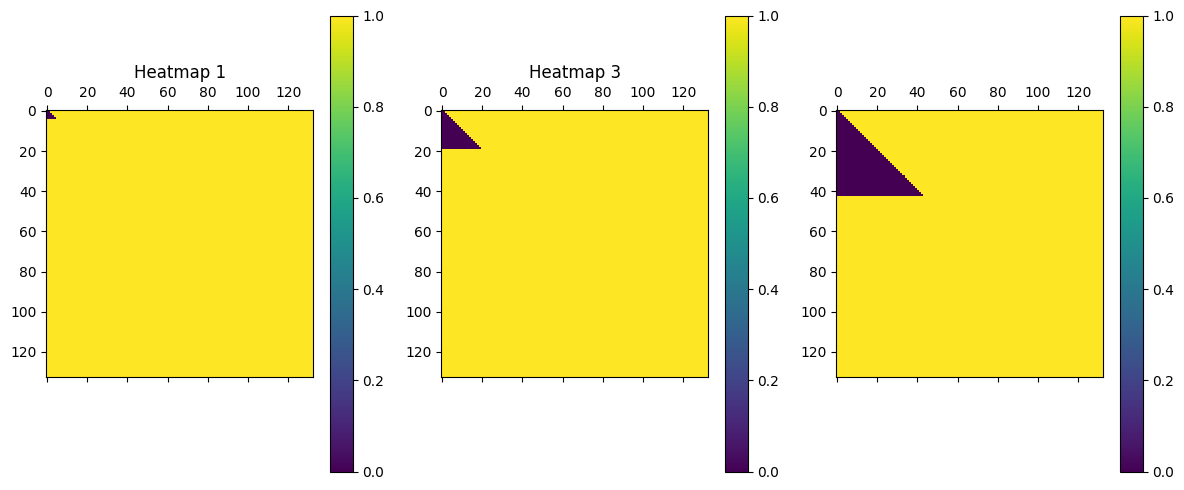

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

cax1 = ax1.matshow(target_masks_fr_torch[0], cmap='viridis')
fig.colorbar(cax1, ax=ax1)
ax1.set_title("Heatmap 1")

cax2 = ax2.matshow(target_masks_fr_torch[7], cmap='viridis')
fig.colorbar(cax2, ax=ax2)
ax2.set_title("Heatmap 2")

cax3 = ax3.matshow(target_masks_fr_torch[9], cmap='viridis')
fig.colorbar(cax3, ax=ax3)
ax2.set_title("Heatmap 3")

plt.tight_layout()
plt.show()


# Data Loader (old flow - ignore)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 8

# Convert data to PyTorch tensors
data_en = torch.tensor(padded_data_en, dtype=torch.long)
data_fr = torch.tensor(padded_data_fr, dtype=torch.long)
mask_en = torch.tensor(attention_masks_en, dtype=torch.bool)
mask_fr = torch.tensor(attention_masks_fr, dtype=torch.bool)
tgt_mask = torch.stack(target_masks_fr_torch)

# Create a dataset and dataloader
dataset = TensorDataset(data_en, data_fr, mask_en, mask_fr, tgt_mask)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# Iterate over batches from the dataloader
for batch_idx, (src, tgt, src_mask, tgt_mask, look_ahead_mask) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("========================================")
    print(f"Source shape: {src.shape}")
    print(f"Target shape: {tgt.shape}")
    print(f"Source mask shape: {src_mask.shape}")
    print(f"Target mask shape: {tgt_mask.shape}")
    print(f"Look-ahead mask shape: {look_ahead_mask.shape}")
    print()

    # For demonstration purposes, let's just check the first two batches
    if batch_idx == 1:
        break


Batch 1:
Source shape: torch.Size([8, 134])
Target shape: torch.Size([8, 133])
Source mask shape: torch.Size([8, 134])
Target mask shape: torch.Size([8, 133])
Look-ahead mask shape: torch.Size([8, 133, 133])

Batch 2:
Source shape: torch.Size([8, 134])
Target shape: torch.Size([8, 133])
Source mask shape: torch.Size([8, 134])
Target mask shape: torch.Size([8, 133])
Look-ahead mask shape: torch.Size([8, 133, 133])



#

# Dataset processing

In [18]:
%%capture
!pip install datasets tokenizers


In [19]:
# reproducibility

import random
import numpy as np
import torch
from torch.utils.data import random_split

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [20]:
from datasets import load_dataset
dataset = load_dataset("opus_books", "en-fr", split='train[:100000]')

In [21]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

SPECIAL_TOKENS = ["[UNK]", "[PAD]", "[SOS]", "[EOS]"]
UNK_TOKEN = "[UNK]"

def train_tokenizer(dataset, language):
    def get_all_sentences(ds, lang):
        return (item['translation'][lang] for item in ds)

    tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
    tokenizer.pre_tokenizer = Whitespace()

    trainer = WordLevelTrainer(special_tokens=SPECIAL_TOKENS)
    tokenizer.train_from_iterator(get_all_sentences(dataset, language), trainer=trainer)

    return tokenizer

tokenizer_en = train_tokenizer(dataset, 'en')
tokenizer_fr = train_tokenizer(dataset, 'fr')

In [22]:
def tokenize_data(data, tokenizer):
    return [tokenizer.encode(text).ids for text in data]

def get_max_seq_length(tokenized_data):
    return max(len(seq) for seq in tokenized_data)

src_texts = [item['translation']['en'] for item in dataset]
tgt_texts = [item['translation']['fr'] for item in dataset]

tokenized_src = tokenize_data(src_texts, tokenizer_en)
tokenized_tgt = tokenize_data(tgt_texts, tokenizer_fr)

SRC_SEQ_LEN = get_max_seq_length(tokenized_src) + 2  # +2 for [SOS] and [EOS] tokens
TGT_SEQ_LEN = get_max_seq_length(tokenized_tgt) + 2  # +2 for [SOS] and [EOS] tokens
MAX_SEQ_LEN = max(SRC_SEQ_LEN, TGT_SEQ_LEN)

print("SRC_SEQ_LEN: ", SRC_SEQ_LEN)
print("TGT_SEQ_LEN: ", TGT_SEQ_LEN)
print("MAX_SEQ_LEN: ", MAX_SEQ_LEN)




SRC_SEQ_LEN:  473
TGT_SEQ_LEN:  484
MAX_SEQ_LEN:  484


In [23]:
import torch
from torch.utils.data import random_split

# Determine sizes for each split
train_dataset_size = int(0.8 * len(dataset))
val_dataset_size = int(0.1 * len(dataset))
test_dataset_size = len(dataset) - train_dataset_size - val_dataset_size

# Split the dataset
train_dataset_raw, val_dataset_raw, test_dataset_raw = random_split(dataset, [train_dataset_size, val_dataset_size, test_dataset_size])


In [24]:
print(len(train_dataset_raw))
print(len(val_dataset_raw))
print(len(test_dataset_raw))

80000
10000
10000


In [25]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.seq_len = seq_len
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def _process_text(self, text, tokenizer):
        """Tokenize text and handle SOS, EOS, and padding."""
        tokens = tokenizer.encode(text).ids
        num_padding_tokens = self.seq_len - len(tokens) - 2  # Account for SOS and EOS tokens
        if num_padding_tokens < 0:
            raise ValueError("Sentence exceeds maximum sequence length")

        # Concatenate tokens with special tokens and padding
        return torch.cat([
            self.sos_token,
            torch.tensor(tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * num_padding_tokens, dtype=torch.int64)
        ], dim=0)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        encoder_input = self._process_text(src_text, self.tokenizer_src)
        decoder_input = self._process_text(tgt_text, self.tokenizer_tgt)

        # Create label for the target text, without the SOS token but with the EOS token
        label = torch.cat([
            torch.tensor(self.tokenizer_tgt.encode(tgt_text).ids, dtype=torch.int64),
            self.eos_token
        ], dim=0)
        label = torch.cat([label, torch.tensor([self.pad_token] * (self.seq_len - len(label)), dtype=torch.int64)], dim=0)

        return {
            "encoder_input": encoder_input,
            "decoder_input": decoder_input,
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(1).int(),
            "decoder_mask": ((decoder_input != self.pad_token).unsqueeze(1).int() & causal_mask(decoder_input.size(0))).int(),
            "label": label,
            "src_text": src_text,
            "tgt_text": tgt_text
        }

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0


In [26]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

# Create instances of the dataset for training, validation, and test data
train_dataset = TranslationDataset(train_dataset_raw, tokenizer_en, tokenizer_fr, 'en', 'fr', MAX_SEQ_LEN)
val_dataset = TranslationDataset(val_dataset_raw, tokenizer_en, tokenizer_fr, 'en', 'fr', MAX_SEQ_LEN)
test_dataset = TranslationDataset(test_dataset_raw, tokenizer_en, tokenizer_fr, 'en', 'fr', MAX_SEQ_LEN)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Google Drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os

# Define paths
base_path = '/content/drive/MyDrive/Colab Notebooks/transformer-model-01'
model_save_path = os.path.join(base_path, 'model_weights')
tokenizer_en_save_path = os.path.join(base_path, 'tokenizer_en')
tokenizer_fr_save_path = os.path.join(base_path, 'tokenizer_fr')

# Ensure directories exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(tokenizer_en_save_path, exist_ok=True)
os.makedirs(tokenizer_fr_save_path, exist_ok=True)



# Model Initialization

In [27]:
# Model Hyperparameters

SRC_VOCAB_SIZE = tokenizer_en.get_vocab_size()
TGT_VOCAB_SIZE = tokenizer_fr.get_vocab_size()
EMBED_SIZE = 128
N = 1 # Number of encoder and decoder blocks
H = 4 # Number of attention heads
DROPOUT = 0.1
D_FF = 2048

# Initialize the transformer model
model = build_transformer(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, MAX_SEQ_LEN, EMBED_SIZE, N, H, DROPOUT, D_FF)

# Check if CUDA is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"SRC_VOCAB_SIZE:", SRC_VOCAB_SIZE)
print(f"TGT_VOCAB_SIZE:", TGT_VOCAB_SIZE)
print(f"MAX_SEQ_LEN:", MAX_SEQ_LEN)


SRC_VOCAB_SIZE: 30000
TGT_VOCAB_SIZE: 30000
MAX_SEQ_LEN: 484


# Training Loop

In [28]:
def validate(model, val_dataloader, loss_fn, device):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            src = batch["encoder_input"].to(device)
            tgt = batch["decoder_input"].to(device)
            src_mask = batch["encoder_mask"].to(device)
            tgt_mask = batch["decoder_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(src, tgt, src_mask, tgt_mask)
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    model.train()
    return avg_val_loss

In [29]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(data_loader, model, tokenizer_en, tokenizer_fr, device):
    model.eval()

    references = []  # Actual target sentences
    hypotheses = []  # Model's translations

    with torch.no_grad():
        for batch in data_loader:
            # Extract source and target sentences from the batch
            src = batch["encoder_input"].to(device)
            tgt = batch["label"].to(device)

            # Translate the source sentences
            translated = [translate_sentence(sentence_tensor, model, tokenizer_en, tokenizer_fr, MAX_SEQ_LEN, device)
                          for sentence_tensor in src]

            hypotheses.extend(translated)
            references.extend([tgt_str.split() for tgt_str in tokenizer_fr.decode_batch(tgt.cpu().tolist())])

    # Compute BLEU score
    bleu_score = corpus_bleu(references, hypotheses)

    return bleu_score

def translate_sentence(sentence_tensor, model, tokenizer_en, tokenizer_fr, max_seq_len, device):
    # Convert tensor back to string
    sentence = tokenizer_en.decode(sentence_tensor.cpu().tolist(), skip_special_tokens=True)

    # Tokenize the source text
    encoding = tokenizer_en.encode(sentence, add_special_tokens=True)
    tokens = encoding.ids

    # Handle truncation manually if sequence length exceeds max_seq_len
    if len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len-1]  # Leave space for [EOS]
    tokens = tokens + [tokenizer_en.token_to_id("[EOS]")]

    tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(device)

    # Create a source mask
    src_mask = (tokens_tensor != tokenizer_en.token_to_id("[PAD]")).unsqueeze(-2).to(device)

    # Start decoding with the [SOS] token
    decoder_input = torch.tensor([tokenizer_fr.token_to_id("[SOS]")]).unsqueeze(0).to(device)
    output_tokens = []

    for _ in range(max_seq_len):
        with torch.no_grad():
            logits = model(tokens_tensor, decoder_input, src_mask, None)  # No target mask in inference
        next_token = logits.argmax(2)[:, -1].unsqueeze(1)
        output_tokens.append(next_token.item())
        decoder_input = torch.cat([decoder_input, next_token], dim=1)

        # Stop decoding once the [EOS] token is generated
        if next_token.item() == tokenizer_fr.token_to_id("[EOS]"):
            break

    # Decode the outputs to get the translated sentence
    decoded = tokenizer_fr.decode(output_tokens, skip_special_tokens=True)

    return decoded.split()  # Return the sentence as a list of words



In [16]:
%%capture
!pip install tensorboard

In [30]:
%%time

import torch.optim as optim
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

# Create a summary writer object. The logs will be saved in the 'runs' directory.
writer = SummaryWriter()


# Hyperparameters
EPOCHS = 10
LR = 0.001
PRINT_EVERY = len(train_dataloader) // 16  # Adjust as needed

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)


# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize with a high value
early_stop_counter = 0  # Counter to track non-improvement epochs

best_bleu = 0.0

train_losses = []
val_losses = []


# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    start_time = time.time()

    for idx, batch in enumerate(train_dataloader):

        # Extract data from the batch
        src = batch["encoder_input"].to(device)
        tgt = batch["decoder_input"].to(device)
        src_mask = batch["encoder_mask"].to(device)
        tgt_mask = batch["decoder_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        logits = model(src, tgt, src_mask, tgt_mask)


        # Compute the loss
        loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every few batches
        if (idx + 1) % PRINT_EVERY == 0:
            print(f"Epoch {epoch + 1}/{EPOCHS} | Batch {idx + 1}/{len(train_dataloader)} | Current Batch Loss: {loss.item():.4f}")

    model.eval()
    val_loss = validate(model, val_dataloader, loss_fn, device)
    print(f"Validation Loss after Epoch {epoch + 1}/{EPOCHS}: {val_loss:.4f}")
    # bleu = calculate_bleu(val_dataloader, model, tokenizer_en, tokenizer_fr, device)
    # print(f"Epoch {epoch + 1}/{EPOCHS} | BLEU Score: {bleu*100:.2f}")


    # Checkpoint model based on BLEU score
    # if bleu > best_bleu:
    #     best_bleu = bleu
    #     torch.save(model.state_dict(), f'{model_save_path}/best_bleu_model_weights.pth')
    #     print(f"New best BLEU! Model saved to {model_save_path}/best_bleu_model_weights.pth")

    # Log training loss
    writer.add_scalar('Loss/train', loss.item(), epoch)

    # Log validation loss
    writer.add_scalar('Loss/validation', val_loss, epoch)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), f'{model_save_path}/model_weights_epoch_{epoch + 1}.pth')
        tokenizer_en.save(f'{tokenizer_en_save_path}/tokenizer_en_directory_epoch_{epoch + 1}')
        tokenizer_fr.save(f'{tokenizer_fr_save_path}/tokenizer_fr_directory_epoch_{epoch + 1}')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping due to no improvement in validation loss!")
            break

    end_time = time.time()
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{EPOCHS} | Avg Loss: {avg_loss:.4f} | Time Taken: {end_time - start_time:.2f} seconds")

    # for monitoring training and validation curves
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    avg_val_loss = validate(model, val_dataloader, loss_fn, device)
    val_losses.append(avg_val_loss)


torch.save(model.state_dict(), f'{model_save_path}/final_model_weights.pth')
tokenizer_en.save(f'{tokenizer_en_save_path}/final_tokenizer_en_directory')
tokenizer_fr.save(f'{tokenizer_fr_save_path}/final_tokenizer_fr_directory')

writer.close()




Epoch 1/10 | Batch 312/5000 | Current Batch Loss: 0.3374
Epoch 1/10 | Batch 624/5000 | Current Batch Loss: 0.3822
Epoch 1/10 | Batch 936/5000 | Current Batch Loss: 0.2426
Epoch 1/10 | Batch 1248/5000 | Current Batch Loss: 0.2798
Epoch 1/10 | Batch 1560/5000 | Current Batch Loss: 0.2762
Epoch 1/10 | Batch 1872/5000 | Current Batch Loss: 0.2230
Epoch 1/10 | Batch 2184/5000 | Current Batch Loss: 0.3615
Epoch 1/10 | Batch 2496/5000 | Current Batch Loss: 0.3129
Epoch 1/10 | Batch 2808/5000 | Current Batch Loss: 0.2861
Epoch 1/10 | Batch 3120/5000 | Current Batch Loss: 0.2992
Epoch 1/10 | Batch 3432/5000 | Current Batch Loss: 0.2731
Epoch 1/10 | Batch 3744/5000 | Current Batch Loss: 0.2611
Epoch 1/10 | Batch 4056/5000 | Current Batch Loss: 0.2103
Epoch 1/10 | Batch 4368/5000 | Current Batch Loss: 0.1356
Epoch 1/10 | Batch 4680/5000 | Current Batch Loss: 0.1441
Epoch 1/10 | Batch 4992/5000 | Current Batch Loss: 0.2796
Validation Loss after Epoch 1/10: 0.2315
Epoch 1/10 | Avg Loss: 0.3157 | Ti

In [2]:
import time

while True:
    print("\n------")
    !nvidia-smi
    print("------\n")
    time.sleep(60)


------
Fri Sep  8 17:25:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


KeyboardInterrupt: ignored

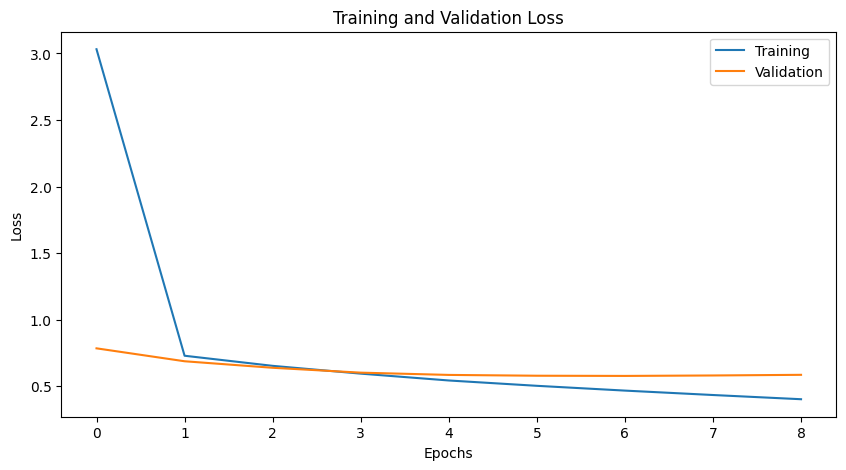

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# First, unload the TensorBoard extension to make sure it's fully stopped.
%load_ext tensorboard
%tensorboard --logdir runs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7418), started 0:02:43 ago. (Use '!kill 7418' to kill it.)

<IPython.core.display.Javascript object>

# Download Tensorboard files

In [ ]:
!zip -r /content/runs.zip /content/runs/


In [ ]:
from google.colab import files
files.download('/content/runs.zip')


# Inference

In [ ]:
%%capture
!pip install tokenizers

In [ ]:
from tokenizers import Tokenizer

# Paths where tokenizers were saved
tokenizer_en_path = f"{tokenizer_en_save_path}/final_tokenizer_en_directory"
tokenizer_fr_path = f"{tokenizer_fr_save_path}/final_tokenizer_fr_directory"

# Load the tokenizers
tokenizer_en = Tokenizer.from_file(tokenizer_en_path)
tokenizer_fr = Tokenizer.from_file(tokenizer_fr_path)




In [ ]:
# Model Hyperparameters

MAX_SEQ_LEN = 234

SRC_VOCAB_SIZE = tokenizer_en.get_vocab_size()
TGT_VOCAB_SIZE = tokenizer_fr.get_vocab_size()
EMBED_SIZE = 128
N = 1 # Number of encoder and decoder blocks
H = 4 # Number of attention heads
DROPOUT = 0.1
D_FF = 2048

# Initialize the transformer model
model = build_transformer(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, MAX_SEQ_LEN, EMBED_SIZE, N, H, DROPOUT, D_FF)

# Check if CUDA is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"SRC_VOCAB_SIZE:", SRC_VOCAB_SIZE)
print(f"TGT_VOCAB_SIZE:", TGT_VOCAB_SIZE)
print(f"MAX_SEQ_LEN:", MAX_SEQ_LEN)

SRC_VOCAB_SIZE: 8534
TGT_VOCAB_SIZE: 10873
MAX_SEQ_LEN: 234


In [ ]:
model_path = f"{model_save_path}/final_model_weights.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))



<All keys matched successfully>

In [18]:

model.eval()
model.to(device)

def translate_sentence(sentence, model, tokenizer_en, tokenizer_fr, max_seq_len, device):
    # Tokenize the source text
    encoding = tokenizer_en.encode(sentence, add_special_tokens=True)
    tokens = encoding.ids

    # Handle truncation manually if sequence length exceeds max_seq_len
    if len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len-1]  # Leave space for [EOS]
    tokens = tokens + [tokenizer_en.token_to_id("[EOS]")]

    tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(device)

    print("tokens_tensor: ", tokens_tensor)

    # Create a source mask
    src_mask = (tokens_tensor != tokenizer_en.token_to_id("[PAD]")).unsqueeze(-2).to(device)

    print("src_mask:", src_mask)

    # Start decoding with the [SOS] token
    decoder_input = torch.tensor([tokenizer_fr.token_to_id("[SOS]")]).unsqueeze(0).to(device)
    output_tokens = []

    for _ in range(max_seq_len):
        with torch.no_grad():
            logits = model(tokens_tensor, decoder_input, src_mask, None)  # No target mask in inference
        next_token = logits.argmax(2)[:, -1].unsqueeze(1)
        output_tokens.append(next_token.item())
        decoder_input = torch.cat([decoder_input, next_token], dim=1)

        # Stop decoding once the [EOS] token is generated
        if next_token.item() == tokenizer_fr.token_to_id("[EOS]"):
            break

    # Decode the outputs to get the translated sentence
    decoded = tokenizer_fr.decode(output_tokens, skip_special_tokens=True)

    return decoded


source_sentence = "The best day"
translated = translate_sentence(source_sentence, model, tokenizer_en, tokenizer_fr, MAX_SEQ_LEN, device)
print(translated)




tokens_tensor:  tensor([[ 49, 537, 125,   3]], device='cuda:0')
src_mask: tensor([[[True, True, True, True]]], device='cuda:0')
Le meilleur jour .


# Evaluate model on test set

In [31]:
model.eval()

def evaluate_on_test(model, test_dataloader, loss_fn, device):
    total_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            # Extract data from the batch
            src = batch["encoder_input"].to(device)
            tgt = batch["decoder_input"].to(device)
            src_mask = batch["encoder_mask"].to(device)
            tgt_mask = batch["decoder_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            logits = model(src, tgt, src_mask, tgt_mask)

            # Compute the loss
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            total_loss += loss.item()

    avg_test_loss = total_loss / len(test_dataloader)
    return avg_test_loss

test_loss = evaluate_on_test(model, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")



Test Loss: 0.1987


# Evaluate Translations

In [19]:
model.eval()


import random

# Choose a random batch from the test dataloader
batch = next(iter(test_dataloader))

# Extract a few samples from the batch
num_samples = 5
indices = random.sample(range(batch['encoder_input'].shape[0]), num_samples)

for idx in indices:
    source_sentence = tokenizer_en.decode(batch['encoder_input'][idx].tolist(), skip_special_tokens=True)
    actual_translation = tokenizer_fr.decode(batch['label'][idx].tolist(), skip_special_tokens=True)

    # Model's translation
    translated_sentence = translate_sentence(source_sentence, model, tokenizer_en, tokenizer_fr, MAX_SEQ_LEN, device)

    print(f"Source Sentence: {source_sentence}")
    print(f"Model's Translation: {translated_sentence}")
    print(f"Actual Translation: {actual_translation}")
    print("="*80)


tokens_tensor:  tensor([[  225,   590,     4,   349,     4,    58,    50,   151,  3727,   365,
            23,  1094,     9,   744,    45,     5,  5347,  1713,     7,    10,
         18719,  3185,    12,     5,  2559,    16,    17,    14,     8,  1324,
             5,   319,  1296,     4,     9,  3681,    14,     5,     6,     3]],
       device='cuda:0')
src_mask: tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True]]], device='cuda:0')
Source Sentence: At present , indeed , they were well supplied both with news and happiness by the recent arrival of a militia regiment in the neighbourhood ; it was to remain the whole winter , and Meryton was the .
Model's Translation: Au but , ils furent bien servis à souhait d ’ un bonheur et de Lydia , par la nouvelle demeure

# Evaluate BLEU scores

In [32]:
def translate_sentence(sentence, model, tokenizer_en, tokenizer_fr, max_seq_len, device):
    # Tokenize the source text
    encoding = tokenizer_en.encode(sentence, add_special_tokens=True)
    tokens = encoding.ids

    # Handle truncation manually if sequence length exceeds max_seq_len
    if len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len-1]  # Leave space for [EOS]
    tokens = tokens + [tokenizer_en.token_to_id("[EOS]")]

    tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(device)

    # Create a source mask
    src_mask = (tokens_tensor != tokenizer_en.token_to_id("[PAD]")).unsqueeze(-2).to(device)

    # Start decoding with the [SOS] token
    decoder_input = torch.tensor([tokenizer_fr.token_to_id("[SOS]")]).unsqueeze(0).to(device)
    output_tokens = []

    for _ in range(max_seq_len):
        with torch.no_grad():
            logits = model(tokens_tensor, decoder_input, src_mask, None)  # No target mask in inference
        next_token = logits.argmax(2)[:, -1].unsqueeze(1)
        output_tokens.append(next_token.item())
        decoder_input = torch.cat([decoder_input, next_token], dim=1)

        # Stop decoding once the [EOS] token is generated
        if next_token.item() == tokenizer_fr.token_to_id("[EOS]"):
            break

    # Decode the outputs to get the translated sentence
    decoded = tokenizer_fr.decode(output_tokens, skip_special_tokens=True)

    return decoded

In [38]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(data_loader, model, tokenizer_en, tokenizer_fr, device):
    model.eval()

    references = []  # Actual target sentences
    hypotheses = []  # Model's translations

    with torch.no_grad():
        for batch in data_loader:
            # Extract source and target sentences from the batch
            src = batch["encoder_input"].to(device)
            tgt = batch["label"].to(device)

            # Translate the source sentences
            translated = [translate_sentence(tokenizer_en.decode(sentence.tolist(), skip_special_tokens=True),
                                              model, tokenizer_en, tokenizer_fr, MAX_SEQ_LEN, device)
                          for sentence in src]

            tgt = [tokenizer_fr.decode(t.tolist(), skip_special_tokens=True) for t in tgt]

            hypotheses.extend(translated)
            for t in tgt:
                references.append([t])  # Note the list inside a list

    # Compute BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score






In [39]:
# Test first on small dataset

# 1. Create a subset of the test dataset
small_test_subset = torch.utils.data.Subset(test_dataset, indices=range(50))

# 2. Create a DataLoader for this subset
small_test_dataloader = torch.utils.data.DataLoader(small_test_subset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Compute the BLEU score using the smaller DataLoader
bleu_score_small = calculate_bleu(small_test_dataloader, model, tokenizer_en, tokenizer_fr, device)
print(f"Small Test BLEU Score: {bleu_score_small:.4f}")


Small Test BLEU Score: 0.1525


In [ ]:
# After computing the test loss:
bleu_score = calculate_bleu(test_dataloader, model, tokenizer_en, tokenizer_fr, device)
print(f"Test BLEU Score: {bleu_score:.4f}")

# Parameter Count

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 11517928


In [ ]:
# manual parameter count

source_embeddings = SRC_VOCAB_SIZE * EMBED_SIZE
target_embeddings = TGT_VOCAB_SIZE * EMBED_SIZE
embeddings = source_embeddings + target_embeddings

encoder_block = (4*EMBED_SIZE*EMBED_SIZE)+(2*EMBED_SIZE*D_FF)
decoder_block = (8*EMBED_SIZE*EMBED_SIZE)+(2*EMBED_SIZE*D_FF)

output = EMBED_SIZE * TGT_VOCAB_SIZE

total_paramter_count = embeddings + N*encoder_block + N*decoder_block + output
print("number of parameters: ", total_paramter_count)

number of parameters:  48300032


In [ ]:
# manual parameter count with biases

# Embeddings
source_embeddings = SRC_VOCAB_SIZE * EMBED_SIZE
target_embeddings = TGT_VOCAB_SIZE * EMBED_SIZE
embeddings = source_embeddings + target_embeddings

# Encoder
encoder_self_attention = 4 * EMBED_SIZE * EMBED_SIZE + 4 * EMBED_SIZE  # Including biases
encoder_ffn = 2 * EMBED_SIZE * D_FF + EMBED_SIZE + D_FF  # Including biases
encoder_layer_norm = 2 * 2 * EMBED_SIZE  # 2 (gamma and beta) for 2 layer norms
encoder_block = encoder_self_attention + encoder_ffn + encoder_layer_norm

# Decoder
decoder_self_attention = 4 * EMBED_SIZE * EMBED_SIZE + 4 * EMBED_SIZE  # Including biases
decoder_cross_attention = 4 * EMBED_SIZE * EMBED_SIZE + 4 * EMBED_SIZE  # Including biases
decoder_ffn = 2 * EMBED_SIZE * D_FF + EMBED_SIZE + D_FF  # Including biases
decoder_layer_norm = 3 * 2 * EMBED_SIZE  # 2 (gamma and beta) for 3 layer norms
decoder_block = decoder_self_attention + decoder_cross_attention + decoder_ffn + decoder_layer_norm

# Output Layer
output = EMBED_SIZE * TGT_VOCAB_SIZE

total_parameter_count = embeddings + N * encoder_block + N * decoder_block + output
print("Adjusted number of parameters: ", total_parameter_count)


Adjusted number of parameters:  48316416


In [ ]:
from tqdm.notebook import tqdm
import time

for _ in tqdm(range(10)):
    time.sleep(0.5)


  0%|          | 0/10 [00:00<?, ?it/s]

# Additional Notes

## Position Encoding code explanation

1. **Initialization**:
```python
pe = torch.zeros(max_len, embed_size)
```
This initializes a matrix of size `(max_len, embed_size)`, where `max_len` is the maximum sequence length and `embed_size` is the embedding size. Each row of this matrix corresponds to a position in a sequence, and each column corresponds to a dimension in the embedding space.

2. **Position Vector Creation**:
```python
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
```
This creates a vector of size `(max_len, 1)`. Each element of this vector is essentially the index of the position in a sequence.

3. **Division Term Computation**:
```python
div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(base) / embed_size))
```
This computes the `div_term` used in the positional encoding formula. This tensor is of size `(embed_size//2,)`, which means it has half the size of the embedding size. We use `embed_size, 2` in `arange` to skip every other value because the positional encoding formula applies the sine function to even indices and the cosine function to odd indices.

4. **Applying the Positional Encoding Formula**:
```python
pe[:, 0::2] = torch.sin(position * div_term)  # sine applied to even indices
pe[:, 1::2] = torch.cos(position * div_term)  # cosine applied to odd indices
```
For the sine function:
- `position * div_term` results in broadcasting, so its size becomes `(max_len, embed_size//2)`.
- `pe[:, 0::2]` selects all rows and even columns of the `pe` matrix. Thus, the size is `(max_len, embed_size//2)`.
  
For the cosine function:
- The size remains `(max_len, embed_size//2)` since it's the same operation but applied to the odd columns of the `pe` matrix.

5. **Add Batch Dimension**:
```python
pe = pe.unsqueeze(0)  # Add a batch dimension for broadcasting
```
The `unsqueeze(0)` function adds a new dimension at the beginning of the tensor, making its size `(1, max_len, embed_size)`. This allows for broadcasting the positional encodings to any batch size when adding them to the embeddings.

In summary, the code generates a positional encoding matrix that, when added to embeddings of sequences, provides the model with information about the position of each token in the sequence.

---

The line `x = x + self.pe[:, :x.size(1)]` is adding the positional encoding to the input embeddings `x`.

Let's break it down:

1. `x`: This is a tensor representing the embeddings of a batch of sequences. Its shape is typically `(batch_size, seq_len, embed_size)`.
    - `batch_size` is the number of sequences in the batch.
    - `seq_len` is the length of each sequence in the batch (after padding if any).
    - `embed_size` is the size of the embedding for each token in the sequence.

2. `self.pe`: This is the tensor that contains the pre-computed positional encodings for all possible positions up to `max_len`. Its shape is `(1, max_len, embed_size)`, as defined in the PositionalEncoding class you provided earlier.

3. `self.pe[:, :x.size(1)]`: This slices the `self.pe` tensor to match the sequence length of the current batch `x`.
    - `x.size(1)` gets the sequence length of the current batch `x`.
    - `self.pe[:, :x.size(1)]` takes all positional encodings up to the current sequence length. The resulting shape of this sliced tensor is `(1, seq_len, embed_size)`.

4. `x = x + self.pe[:, :x.size(1)]`: This operation adds the positional encodings to the embeddings.
    - Since the first dimension of `self.pe[:, :x.size(1)]` is 1 (batch dimension), it broadcasts to the batch size of `x`.
    - The result is that each sequence in the batch `x` gets the same positional encodings added to it. The updated `x` still has the shape `(batch_size, seq_len, embed_size)`.

In essence, this line ensures that the model is aware of the position of each token within a sequence by adding positional information to the embeddings of the tokens.

In [ ]:
position = torch.arange(0, 10, dtype=torch.float)
print(position.shape)
print(position)

In [ ]:
position = torch.arange(0, 10, dtype=torch.float).unsqueeze(1)
print(position.shape)
print(position)


## Slicing example

Imagine a box of chocolates with 3 layers, where each layer has a set of chocolates arranged in rows and columns. Here's how we can represent this box:

$$
\text{chocolates} =
\begin{bmatrix}
    \text{layer 1 (bottom layer)} \\
    \text{layer 2 (middle layer)} \\
    \text{layer 3 (top layer)}
\end{bmatrix}
$$

Each layer has chocolates arranged in rows and columns:

$$
\text{layer} =
\begin{bmatrix}
    \text{a} & \text{b} & \text{c} & \text{d} \\
    \text{e} & \text{f} & \text{g} & \text{h} \\
    \text{i} & \text{j} & \text{k} & \text{l} \\
    \text{m} & \text{n} & \text{o} & \text{p}
\end{bmatrix}
$$

Now, let's understand the slicing:

1. **First Dimension (Layers)**:
   - `:` means we want all layers, so we're taking the entire box of chocolates.

2. **Second Dimension (Rows)**:
   - `:3` means we want only the first 3 rows from each layer. So, from each layer, we'll exclude the last row.

3. **Third Dimension (Columns)**:
   - `:` means we want all columns from the selected rows.

Using the slicing `[:, :3, :]` on our box of chocolates:

$$
\text{selected\_chocolates} =
\begin{bmatrix}
    \begin{bmatrix}
        \text{a} & \text{b} & \text{c} & \text{d} \\
        \text{e} & \text{f} & \text{g} & \text{h} \\
        \text{i} & \text{j} & \text{k} & \text{l} \\
    \end{bmatrix} \\
    \begin{bmatrix}
        \text{a} & \text{b} & \text{c} & \text{d} \\
        \text{e} & \text{f} & \text{g} & \text{h} \\
        \text{i} & \text{j} & \text{k} & \text{l} \\
    \end{bmatrix} \\
    \begin{bmatrix}
        \text{a} & \text{b} & \text{c} & \text{d} \\
        \text{e} & \text{f} & \text{g} & \text{h} \\
        \text{i} & \text{j} & \text{k} & \text{l} \\
    \end{bmatrix}
\end{bmatrix}
$$

So, using `[:, :3, :]` on our 3D tensor gives us all layers, but only the first 3 rows of chocolates from each layer, and all columns from those rows.

## Layer Normalization

Layer Normalization (LayerNorm) is a normalization technique similar to Batch Normalization (BatchNorm), but with a key difference in the dimensions over which the normalization is computed.

#### What is getting normalized?

In LayerNorm, normalization is applied over the feature dimensions (often referred to as the hidden dimensions or channels). It normalizes the features of each individual item in a batch independently. In contrast, BatchNorm normalizes across the batch dimension.

Given an input tensor of shape \([8, 32, 10]\):
- The first dimension (8) is the batch size.
- The second dimension (32) is the sequence length or time steps.
- The third dimension (10) is the feature size or hidden dimension.

For LayerNorm, normalization is applied over the last dimension (feature size). This means that for each item in the batch and for each time step in the sequence, the features (of size 10 in this example) are normalized such that they have a mean of 0 and a standard deviation of 1.

#### Example:

Let's consider a single data point from the batch (ignoring the batch dimension for simplicity), and a single time step from the sequence (ignoring the sequence dimension as well). This gives us a vector of size 10 (our feature size).

Original feature vector (size 10): \([2, 5, 1, 6, 7, 4, 9, 3, 0, 8]\)

Let's say the computed mean (μ) of this vector is 4.5 and the standard deviation (σ) is 2.9.

Normalized feature vector (size 10) will be:
$$
\left( \frac{[2, 5, 1, 6, 7, 4, 9, 3, 0, 8] - μ}{σ} \right)
$$

This operation will be done for each time step for each item in the batch. After normalization, a learnable scale and shift will be applied to the features. This allows the network to decide the best distribution for the features.

### Benefits:

1. **Stability**: LayerNorm can stabilize the hidden state dynamics in recurrent networks, making training more predictable and stable.
2. **Independence**: LayerNorm normalizes each item independently, making it batch size agnostic. This means the statistics computed for normalization are not dependent on the batch size.
3. **Improved Training**: Like other normalization techniques, LayerNorm often leads to faster convergence and can allow for higher learning rates.

### Conclusion:

To sum up, in the given tensor of size \([8, 32, 10]\), LayerNorm will ensure that for each of the 8 items in the batch, for each of the 32 time steps, the 10 features are normalized individually based on their own mean and standard deviation.

## `nn.LayerNorm`

Using `nn.LayerNorm(embed_size)` from PyTorch's built-in module is indeed a recommended approach for most use cases. The PyTorch team has optimized it for performance, and it abstracts away the internal workings, making it simpler and less prone to mistakes.

Here are some reasons to consider using the built-in `nn.LayerNorm`:

1. **Optimization**: PyTorch's built-in layers are optimized for performance. They often have CUDA implementations that make them faster on GPUs.
2. **Maintainability**: Using built-in layers can make your codebase smaller, more readable, and easier to maintain.
3. **Robustness**: The built-in layers are widely used and tested by the community. They are less likely to have bugs compared to custom implementations.
4. **Compatibility**: Future updates or changes in the PyTorch framework are more likely to remain compatible with their built-in layers.

However, there are scenarios where you might want to implement LayerNorm (or other layers) from scratch:

1. **Educational Purposes**: Implementing layers from scratch is a great way to understand their inner workings.
2. **Custom Modifications**: If you have a variant of LayerNorm that's not captured by the built-in module, you might need a custom implementation.
3. **Research**: When trying out new normalization techniques or building upon LayerNorm, a custom implementation might be necessary.

But for most standard use cases, especially in production models, leveraging the built-in `nn.LayerNorm(embed_size)` is a good choice. If you don't have any specific requirements that necessitate a custom implementation, it's advisable to use the built-in one.

## `contiguous()`

The use of `.contiguous()` followed by `.view()` is often a defensive coding practice to ensure that the reshaping operations with `.view()` do not result in errors. Here's why:

1. **Tensor Memory Layout**: In PyTorch, tensors have their data laid out in memory. When you perform operations like transposing, the logical structure of the tensor changes, but the underlying data might not be rearranged in memory. Instead, PyTorch uses `strides` to index into the same chunk of memory. This can mean the tensor is no longer "contiguous" in memory.

2. **The `.view()` operation**: When you use `.view()`, it returns a new tensor with the desired shape. However, it expects the data to be contiguous in memory. If it's not, you'll get a runtime error.

3. **Using `.contiguous()`**: When you call `.contiguous()`, it physically rearranges the tensor data in memory to make it contiguous. After calling `.contiguous()`, you can safely use `.view()` to reshape the tensor without any errors.

In many cases, especially when the tensor is already contiguous, calling `.contiguous()` is a no-op (i.e., it doesn't do anything). However, after operations that might change the memory layout (like `.transpose()`), it's a good practice to ensure contiguity before reshaping with `.view()`.

In the given code:

```python
x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_size)
```

The tensor `x` is transposed first. The `.contiguous()` ensures that the memory layout is contiguous, and then the tensor is reshaped with `.view()`. This ensures that the code won't break due to non-contiguous memory issues.

## `nn.Dropout`

Dropout is a regularization technique for reducing overfitting in neural networks. It works by randomly setting a fraction of input units to 0 at each update during training time, which helps to prevent overfitting. This fraction is the dropout rate.

### How Does `nn.Dropout` Work?

In PyTorch, `nn.Dropout` works in the following manner:

1. During training:
    - A random set of activations is set to zero.
    - The remaining activations are scaled up by \( \frac{1}{1 - \text{dropout rate}} \) to keep the sum of all activations unchanged.
    
2. During evaluation/testing:
    - No activations are set to zero.
    - No scaling is applied. The module simply returns the input as is.

### Purpose of Multiple Dropout Mechanisms:

Every class has its own dropout mechanism. This approach offers several benefits:

1. **Flexibility**: Different parts of the network might require different dropout rates. For instance, you might want a higher dropout rate in the feed-forward layers and a lower dropout rate in the attention mechanisms.
  
2. **Regularization at Multiple Levels**: By applying dropout at multiple stages or levels in the model, you're introducing regularization throughout the model. This can help in preventing overfitting at different stages of the network.

3. **Diverse Representations**: Dropout can encourage the model to learn more robust and diverse internal representations. By randomly dropping out certain activations, the network is less likely to rely heavily on any single neuron and is encouraged to learn redundant representations.

4. **Avoid Co-adaptation**: Co-adaptation is when two or more neurons detect the same feature. Dropout helps in avoiding this by ensuring that no set of neurons is consistently used together.

### Desired Effect:

The idea behind using dropout in different parts of the Transformer is to ensure that the model doesn't overfit and can generalize well to unseen data. For instance:

1. **Dropout in Attention Mechanisms**: Helps in preventing overfitting in the self-attention calculations.
2. **Dropout in Feed-Forward Layers**: Helps in preventing overfitting in the feed-forward neural networks inside each transformer block.
3. **Dropout in Positional Encodings**: Helps to ensure the model doesn't over-rely on positional information.

Overall, the combination of these individual dropout mechanisms aims to create a model that is robust and can generalize well across various sequences and tasks.

## the `forward` method of the `EncoderBlock`

```python
def forward(self, src: torch.Tensor, src_mask: torch.Tensor) -> torch.Tensor:
    src = self.residual_connections[0](src, lambda src: self.self_attention_block(src, src, src, src_mask))
    src = self.residual_connections[1](src, self.feed_forward_block)
    return src
```

1. **Input Parameters**:
    - `src`: This is the source sequence tensor with a shape typically of `(batch_size, seq_len, embed_size)`.
    - `src_mask`: This is a mask tensor used to ensure that the self-attention mechanism doesn't attend to padding tokens. It has a shape of `(batch_size, 1, 1, seq_len)`.

2. **First Residual Connection**:
   ```python
   src = self.residual_connections[0](src, lambda src: self.self_attention_block(src, src, src, src_mask))
   ```
   - This line applies the first `ResidualConnection`.
   - Inside the residual connection, the input `src` goes through layer normalization first.
   - Then, the normalized `src` is passed to the function provided as the second argument. This function is a lambda function which applies the multi-head self-attention block to the input. In the context of self-attention, the query, key, and value are all the same and are equal to the normalized `src`.
   - The output of the self-attention block is added to the original (unnormalized) `src`, achieving the residual connection.
   - This summed output becomes the new value of `src`.

3. **Second Residual Connection**:
   ```python
   src = self.residual_connections[1](src, self.feed_forward_block)
   ```
   - This line applies the second `ResidualConnection`.
   - Just like before, the input `src` goes through layer normalization first.
   - After normalization, the `feed_forward_block` is applied to the normalized `src`.
   - The output of the feed-forward block is added to the original (unnormalized) `src`, achieving the second residual connection.
   - This summed output becomes the new value of `src`.

4. **Return Value**:
   - Finally, the modified `src` is returned. This will be the input to the next encoder block (if there is one) or will be the final output of the encoder if it's the last block.

In essence, the forward pass of the `EncoderBlock` can be thought of as two main steps: a multi-head self-attention mechanism followed by a pointwise feed-forward network. Each of these steps is wrapped in a residual connection, which means the output of each step is added to its input.

## `encode` and `decode` methods in the `Transformer` class

The `encode` and `decode` methods in the `Transformer` class are particularly useful during the inference phase. Let's discuss their roles and utility:

1. **Inference Phase in Sequence-to-Sequence Models**:
    - In sequence-to-sequence tasks like machine translation, the typical inference process involves encoding the source sequence and then decoding it into the target sequence, often one token at a time.
    
2. **`encode` method**:
    - The `encode` method takes the source sequence and its corresponding mask as inputs. It returns the encoder's output.
    - This encoder's output is then used as context for the decoder. The important point to note is that, once encoded, this context does not change during the decoding of the entire target sequence. It's a static representation of the source sequence for the decoder.

3. **`decode` method**:
    - The `decode` method is used to generate the target sequence.
    - During inference, especially when generating sequences token-by-token (like in beam search or greedy decoding), the `decode` method can be called iteratively, each time with an extended target sequence (with the newly predicted token appended) until a termination condition is met (e.g., a special end-of-sequence token is produced or a maximum sequence length is reached).

4. **Benefits of Separate Methods**:
    - **Modularity**: Having separate methods for encoding and decoding allows for a more modular approach. For example, in tasks like text summarization, after encoding an article, you might want to decode multiple summaries (e.g., a one-sentence summary, a paragraph-length summary).
    - **Efficiency**: Especially during beam search decoding, where multiple candidate sequences are explored, the source sequence remains the same. By encoding it just once and reusing the context, you save computational resources.
    - **Flexibility**: In some advanced applications, you might want to manipulate the encoded context before decoding (e.g., in style transfer tasks). Separate methods make such interventions more straightforward.

5. **Training vs. Inference**:
    - During training, the entire target sequence is often available, and the model is trained to predict each token based on the previous ground-truth tokens (teacher forcing). So, you might not call `encode` and `decode` separately.
    - During inference, however, the model predicts the target sequence iteratively, using its own previous predictions as input for subsequent tokens. This is where having separate `encode` and `decode` methods becomes particularly useful.

In conclusion, while the `encode` and `decode` methods can be useful during both training and inference, their utility becomes especially apparent during the inference phase in sequence-to-sequence tasks.

## `torch.softmax` and `torch.log_softmax`

Both `torch.softmax` and `torch.log_softmax` have their uses, and the best one to use often depends on the context.

1. **Numerical Stability**: When training models, especially deep neural networks, the values can sometimes become very large or very small. When you take the logarithm of a very small number, you can end up with `-inf`, and when you exponentiate a very large number (as done in softmax), you can end up with `inf`. Combining the softmax and log operations into a single `log_softmax` function can help ensure that the computation is stable and avoids these extreme values.

2. **Loss Function Compatibility**: If you're using the negative log likelihood loss (`nn.NLLLoss` in PyTorch), then the input to this loss function should be the log probabilities, which is what `log_softmax` provides. On the other hand, if you were using `nn.CrossEntropyLoss`, this loss function combines `log_softmax` and `nn.NLLLoss` into a single step, so you'd directly provide the raw outputs (logits) of your model.

3. **Interpretability**: If you want the actual probabilities (e.g., for interpretation, analysis, or to provide a probability distribution to an end user), then you'd use `torch.softmax`.

In many transformer-based models, especially when using the negative log likelihood as the loss function, `log_softmax` is commonly used for the reasons of numerical stability and loss compatibility.

Given that the original code uses `log_softmax` for "numerical stability" and you're likely training the model using negative log likelihood, I would recommend sticking with `log_softmax`. When you're computing the loss during training, make sure to pair it with `nn.NLLLoss`. If at any point during inference or post-training analysis you need the actual probabilities, you can always apply the exponential function (`torch.exp`) to convert the log probabilities back into regular probabilities.

## HuggingFace's `datasets`

### 1. Loading the dataset using HuggingFace's `datasets` library:

When you run:

```python
from datasets import load_dataset
dataset = load_dataset("opus_books", "en-fr")
```

The `dataset` variable becomes an instance of the `DatasetDict` class. A `DatasetDict` is essentially a dictionary-like structure with keys corresponding to different splits of the dataset, like 'train', 'test', etc.

### 2. Understanding the dataset type:

You can check the type of `dataset` as follows:

```python
print(type(dataset))
```

This will likely print: `<class 'datasets.dataset_dict.DatasetDict'>`

### 3. Accessing the individual splits:

To access the training split, you'd use:

```python
train_dataset = dataset['train']
```

Similarly, if the dataset contains other splits like 'test' or 'validation', you can access them with `dataset['test']` and `dataset['validation']` respectively.

### 4. Structure of the splits:

Each split (like `train_dataset` in the above example) is an instance of the `Dataset` class. This acts like a list of dictionaries. Each element of the list corresponds to a data example, and the dictionary keys correspond to the different columns or features of the dataset.

For instance, to access the first example's English text, you'd use:

```python
english_text = train_dataset[0]['translation']['en']
```

### 5. Preparing the data:

For training models, especially with PyTorch, you'll typically want your data in the form of tensors. However, the HuggingFace `datasets` library usually loads data in other formats (like lists of dictionaries).

To convert this data into a more suitable format for training, you'll often do the following:

- Tokenize the text data to convert it into numerical format.
- Convert the tokenized data into tensors.
- Use PyTorch's `DataLoader` to batch and shuffle the data.

HuggingFace's `transformers` library provides tokenizers that can help with the tokenization step, and they can directly output PyTorch tensors.

### Example:

Here's a simplified process using a tokenizer from HuggingFace's `transformers`:

```python
from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('model_name_or_path')  # Replace 'model_name_or_path' with a suitable model/tokenizer name

# Tokenize the dataset
tokenized_data = dataset.map(lambda examples: tokenizer(examples['translation']['en'], examples['translation']['fr'], truncation=True, padding='max_length', max_length=100), batched=True)

# Set the format to PyTorch tensors
tokenized_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
```

Now, `tokenized_data` is ready to be used with PyTorch's `DataLoader` for training.


## `torch.utils.data.DataLoader` and `torch.utils.data.TensorDataset`.

### 1. `torch.utils.data.TensorDataset`

**Purpose**:
- `TensorDataset` wraps tensors into a dataset. It allows us to have a multi-input dataset without having to manually handle each item's indexing. For example, if we want to train a model using source sentences and target sentences as inputs, `TensorDataset` can handle this pairing.

**How it works**:
- Given tensors `a` of size `(n, m)` and `b` of size `(n, p)`, it creates a dataset of `n` samples where each sample is a tuple containing a slice of `a` and `b`.

**Usage**:
```python
from torch.utils.data import TensorDataset

# Example tensors
tensor_a = torch.tensor([[1,2], [3,4], [5,6]])
tensor_b = torch.tensor([[10], [20], [30]])

# Create a TensorDataset
dataset = TensorDataset(tensor_a, tensor_b)

# Accessing an item
item = dataset[1]  # Returns (tensor([3,4]), tensor([20]))
```

### 2. `torch.utils.data.DataLoader`

**Purpose**:
- `DataLoader` helps with batching, shuffling, and loading the data in parallel. It provides an iterable over a dataset (like `TensorDataset`).
- It is especially useful because it abstracts away the manual handling of batching and provides a simple interface to loop through data in batches.

**Key Parameters**:
- `dataset`: The dataset from which to load the data (could be a `TensorDataset`, among others).
- `batch_size`: How many samples per batch to load.
- `shuffle`: Whether to shuffle the dataset before each epoch.
- `num_workers`: How many subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process (which can slow down training on GPUs).

**Usage**:
```python
from torch.utils.data import DataLoader

# Using the previously defined TensorDataset 'dataset'
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Looping through the DataLoader
for batch in dataloader:
    batch_a, batch_b = batch
    # Now, 'batch_a' and 'batch_b' are batches from 'tensor_a' and 'tensor_b'
```

In the context of our Transformer model, `DataLoader` will be used to create batches of source sentences, target sentences, and their corresponding masks. This makes it easier to train the model in mini-batches rather than using the entire dataset at once (which might not fit in memory).

## `torch.utils.data.DataLoader`.

### What is `torch.utils.data.DataLoader`?

The `torch.utils.data.DataLoader` is a utility class provided by PyTorch that offers an efficient way to iterate over datasets. It provides functionality to automatically batch, shuffle, and load data in parallel using multiprocessing. It's designed to work seamlessly with instances of the `torch.utils.data.Dataset` class.

### Main Features of `torch.utils.data.DataLoader`:

1. **Batching**: It automatically groups multiple data points into batches, making it easier to process large datasets in chunks.
2. **Shuffling**: For training datasets, you often want to access your data in a random order. DataLoader provides an easy way to shuffle data at the beginning of each epoch.
3. **Parallel Loading with Multiprocessing**: `DataLoader` can use multiple subprocesses to load data in parallel, which can lead to significant speedups, especially when the data loading or preprocessing is CPU-intensive.
4. **Custom Sampling**: It supports custom sampling strategies through the `Sampler` argument.
5. **Automatic Collation**: It automatically collates individual data points into batches, but if your data points are more complex (e.g., different shapes, types), you can provide a custom `collate_fn` to specify how this should be done.
6. **Lazy Loading**: Works well with datasets that support lazy loading, ensuring that only the data that's needed for the current batch gets loaded and processed.

### Main Uses:

1. **Efficient Iteration**: It gives you an iterator that yields batches of data, making it easier to loop through a dataset in a for-loop during training or evaluation.
2. **Training Loop Simplification**: Instead of manually handling batching, shuffling, and data loading, you can rely on DataLoader to handle these details.
3. **Performance Optimization**: By using multiple processes, DataLoader can significantly speed up data loading, which can be a bottleneck in training deep learning models, especially when the preprocessing is involved.

### Step-by-Step Explanation:

1. **Initialization**: When creating a `DataLoader`, you provide it with a `Dataset` and various other arguments that control its behavior (batch size, shuffling, number of workers, etc.).
   
2. **Batching**: One of the primary roles of the `DataLoader` is to take individual data points from the provided `Dataset` and group them into batches. This is controlled by the `batch_size` argument.
   
3. **Shuffling**: If the `shuffle` argument is set to `True`, the `DataLoader` will shuffle the data at the beginning of each epoch. This is crucial for training deep learning models to ensure they don't see data in the same order each time.
   
4. **Parallel Loading**: The `num_workers` argument controls how many subprocesses are used for data loading. If it's greater than 0, data loading will happen in parallel using the specified number of processes, improving loading times.
   
5. **Sampling**: DataLoader can be combined with various `Sampler` classes to define a custom strategy for drawing samples from the dataset. This is useful for imbalanced datasets or other scenarios where specific sampling techniques are beneficial.
   
6. **Collation**: Once individual data points are batched together, they need to be collated (merged) into a single tensor. DataLoader handles this automatically for simple cases but can be customized with the `collate_fn` argument for more complex data structures.
   
7. **Iteration**: Once initialized, the `DataLoader` acts as an iterator. During training or evaluation, you typically loop through the DataLoader to get batches of data.
   
8. **Lazy Loading**: When combined with a `Dataset` that supports lazy loading, the `DataLoader` ensures that only the necessary data is loaded and processed, conserving memory and computational resources.

In essence, `torch.utils.data.DataLoader` is an essential tool in PyTorch that streamlines the data loading process, ensuring that the training loop is efficient, flexible, and easier to manage.

## `torch.utils.data.Dataset`

### What is `torch.utils.data.Dataset`?

The `torch.utils.data.Dataset` is an abstract class provided by PyTorch that represents a dataset. It allows you to build custom datasets by overriding specific methods. This class is especially beneficial when you're working with large datasets that don't fit into memory or when you need to apply some custom transformations on-the-fly during data loading.

### Main Features of `torch.utils.data.Dataset`:

1. **Flexibility**: It's an abstract class, which means you have to provide implementations for some of its methods, allowing you to define exactly how your data is loaded and processed.
2. **Integration with DataLoader**: It's designed to seamlessly integrate with `torch.utils.data.DataLoader`, which provides multi-process data loading, batching, shuffling, and other utilities.
3. **Support for Map-style and Iterable-style datasets**: You can create datasets that are map-like (i.e., they implement the `__getitem__` and `__len__` methods) or iterable-like (i.e., they implement the `__iter__` method).

### Main Uses:

1. **Custom Data Loading**: It provides a consistent interface to load custom data. This is particularly useful when working with domain-specific datasets that aren't catered to by standard libraries.
2. **On-the-fly Data Augmentation/Transformation**: By overriding the `__getitem__` method, you can apply transformations to data points as they're loaded, allowing for dynamic data augmentation.
3. **Lazy Loading**: You don't have to load the entire dataset into memory. Instead, data points can be loaded and processed as needed, which is essential for large datasets.
4. **Custom Sampling**: While not directly a feature of `Dataset`, in combination with `DataLoader` and custom `Sampler` classes, you can define custom sampling strategies for your data.

### Step-by-Step Explanation:

1. **Definition**: At its core, the `Dataset` class is a way of representing data. It's an abstract class, meaning you can't use it directly. Instead, you have to define a subclass and provide implementations for certain methods.
   
2. **Mandatory Methods**:
   - For map-style datasets:
     - `__getitem__(self, index)`: This returns a data point (a sample) given an index. This is where you'd typically apply any on-the-fly transformations or data augmentations.
     - `__len__(self)`: This returns the number of data points in the dataset.
   - For iterable-style datasets:
     - `__iter__(self)`: This should yield samples from the dataset.
   
3. **Usage with DataLoader**: Once you've defined a `Dataset`, you can wrap it with a `DataLoader`. This gives you an iterator that yields batches of data, and it can handle things like shuffling and multi-process data loading for you.
   
4. **Custom Transformations**: One common use-case for custom datasets is applying transformations to the data. By integrating with libraries like `torchvision.transforms`, you can apply a series of transformations every time a data point is fetched.
   
5. **Integration with Other Tools**: Since the `Dataset` class provides a consistent interface for data loading, it can be integrated with other tools or libraries that expect data in a certain format. For instance, tools for visualization, augmentation, or even other machine learning frameworks can work with your data as long as it's represented as a `Dataset`.

6. **Combination with Samplers**: For more advanced sampling techniques (e.g., stratified sampling, weighted sampling), you can use custom `Sampler` classes with the `DataLoader` to control the order in which data points are fetched.

In summary, `torch.utils.data.Dataset` offers a flexible and standardized way to represent and load data in PyTorch, making it easier to work with various types and sizes of datasets in a consistent manner.

## Mask dimensions

There seems to be a discrepancy in dimensions between the `mask_fr` and the `tgt_mask`.

1. `mask_fr` is a 2D tensor of shape `(batch_size, sequence_length)`.
2. `tgt_mask` is a 3D tensor of shape `(batch_size, sequence_length, sequence_length)`.

The difference in dimensions is because:

- `mask_fr` (and `mask_en`) is an **attention mask**, which is used to specify which tokens should be attended to (usually `True` for real tokens and `False` for padding tokens).
- `tgt_mask` is a **combined mask** for the target sequences. It combines the attention mask (to ignore padding tokens) and the look-ahead mask (to ensure that a token in position `i` can't attend to future tokens in positions `j > i`).

When you are using these masks in the Transformer model:

- The source mask (`mask_en`) and target attention mask (`mask_fr`) are used in both the encoder and the decoder to mask out padding tokens.
- The `tgt_mask` (look-ahead mask) is specifically used in the decoder's self-attention mechanism to prevent future tokens from being attended to.

So, while it might seem unusual to have this difference in dimensions, it's actually expected given the use-case of each mask. However, it's essential to ensure that these masks are used correctly in the Transformer model.

## formula for the Transformer model's parameters

Below is a breakdown formula for the Transformer model's parameters:

1. **Embeddings**:
    - Source embeddings: \( \text{SRC\_VOCAB\_SIZE} \times \text{EMBED\_SIZE} \)
    - Target embeddings: \( \text{TGT\_VOCAB\_SIZE} \times \text{EMBED\_SIZE} \)

2. **Positional Encodings**:
    - They do not have trainable parameters.

3. **Encoder**:
    Each Encoder Block has:
    - Self Attention:
        - Query weights: \( \text{EMBED\_SIZE} \times \text{EMBED\_SIZE} \)
        - Key weights: \( \text{EMBED\_SIZE} \times \text{EMBED\_SIZE} \)
        - Value weights: \( \text{EMBED\_SIZE} \times \text{EMBED\_SIZE} \)
        - Output projection weights: \( \text{EMBED\_SIZE} \times \text{EMBED\_SIZE} \)
    - Feed Forward Network:
        - Input layer: \( \text{EMBED\_SIZE} \times \text{D\_FF} \)
        - Output layer: \( \text{D\_FF} \times \text{EMBED\_SIZE} \)
    
    Total for each Encoder Block: \( 4 \times \text{EMBED\_SIZE} \times \text{EMBED\_SIZE} + 2 \times \text{EMBED\_SIZE} \times \text{D\_FF} \)

4. **Decoder**:
    Each Decoder Block has:
    - Self Attention (same as in Encoder)
    - Cross Attention (same structure as Self Attention)
    - Feed Forward Network (same as in Encoder)
    
    Total for each Decoder Block: \( 8 \times \text{EMBED\_SIZE} \times \text{EMBED\_SIZE} + 2 \times \text{EMBED\_SIZE} \times \text{D\_FF} \)

5. **Output Layer**:
    - \( \text{EMBED\_SIZE} \times \text{TGT\_VOCAB\_SIZE} \)

To get the total number of parameters, you can multiply the parameters for each block by the number of blocks \( N \) and then sum up the parameters from the embeddings, all encoder blocks, all decoder blocks, and the output layer.

You can use the above formulas in your Colab to compute the total number of parameters.

## The embedding size, d_model

The embedding size, d_model, in the Transformer architecture significantly affects the model's capacity and, therefore, its performance. The choice of embedding size is a trade-off between computational cost (both in terms of memory and processing time) and model performance.

When considering the embedding size, here are some points to consider:

1. **Model Capacity**: A larger embedding size increases the model's capacity, allowing it to potentially capture more intricate patterns in the data. This could be beneficial for complex tasks or large datasets. However, a model with a larger capacity can also overfit more easily if not properly regularized or if trained on a small dataset.

2. **Computational Cost**: As you've noticed, the embedding size significantly affects the total number of parameters in the model. This has implications for training time, memory usage, and deployment considerations.

3. **Task Complexity**: For simpler tasks or smaller datasets, a large embedding size might be overkill and could lead to overfitting. For such tasks, reducing the embedding size (and potentially the number of layers) might be appropriate.

4. **Empirical Results**: Often, the best way to determine the right embedding size is through empirical testing. By training models with different embedding sizes and evaluating their performance on a validation set, you can select the size that works best for your specific task and dataset.

5. **Literature and Pre-trained Models**: The choice of 512 for the embedding size in the original "Attention Is All You Need" paper was based on their experiments and the scale of the tasks they were addressing (like machine translation on the WMT dataset). However, different tasks or datasets might benefit from different sizes. It's always a good idea to check recent literature or related works for your specific task to see if there are recommended embedding sizes.

6. **Transfer Learning**: If you plan to leverage pre-trained models and fine-tune them on your task, you'd typically want to use the same embedding size as the pre-trained model to benefit from the learned representations.

For a small project, if computational resources are limited, or if you're dealing with a less complex dataset, you might consider reducing the embedding size. Values like 256 or even 128 could be a starting point. However, the best approach would be to empirically test a few different sizes to see which one offers the best trade-off between performance and computational efficiency for your specific use case.

## `tqdm`

`tqdm` is a Python library that provides a fast, extensible progress bar for loops and other computations. The name "tqdm" stands for the Arabic word "taqaddum" (تقدّم) which means "progress."

Here's what `tqdm` offers:

1. **Instant Feedback**: It provides instant feedback by showing a progress bar that estimates how much time is left for the loop or computation to complete.
  
2. **Versatility**: It works on any iterable, including lists, dictionaries, and even files.
  
3. **Extensibility**: It can be used in a variety of environments, such as the command line, Jupyter notebooks, and graphical interfaces.
  
4. **Customizability**: The appearance and information displayed by the progress bar can be customized.

5. **Additional Utilities**: Beyond the basic progress bar, `tqdm` also provides utilities for tracking download progress, parallel processing, and more.

### Basic Usage:

Here's a simple example of how to use `tqdm`:

```python
from tqdm import tqdm
import time

for _ in tqdm(range(10)):
    time.sleep(0.5)
```

When you run the above code, you'll see a progress bar in the console that updates in real-time, showing the number of iterations completed, the total number of iterations, the percentage completed, the time elapsed, and an estimate of the time remaining.

In Jupyter notebooks, you can use `tqdm.notebook.tqdm` for a better-looking, notebook-friendly progress bar:

```python
from tqdm.notebook import tqdm

for _ in tqdm(range(10)):
    time.sleep(0.5)
```

Overall, `tqdm` is an invaluable tool for long computations where you want to keep track of progress and estimated completion time.

## `tensor.masked_fill_`

The `masked_fill_` method is a very useful in-place operation provided by PyTorch for tensors. Let's break down its functionality:

### `masked_fill_`

**Purpose**:
To update specific elements of a tensor based on a boolean mask.

**Syntax**:
```python
tensor.masked_fill_(mask, value)
```

**Parameters**:

- `mask` (BoolTensor): A boolean tensor with the same shape as the original tensor (`tensor`). The mask specifies which elements in the tensor should be updated. A `True` value in the mask means the corresponding element in the tensor will be updated, while a `False` value means it will be left unchanged.
  
- `value`: The scalar value used to update the tensor's elements specified by the mask.

**In-place**:
The underscore at the end of `masked_fill_` means it's an in-place operation. This means that the tensor is modified directly and nothing is returned. There's also a non-in-place version called `masked_fill` which returns a new tensor.

**Example**:
```python
import torch

x = torch.tensor([[1, 2], [3, 4]])
mask = torch.tensor([[True, False], [False, True]])
x.masked_fill_(mask, -1)
print(x)
```
Output:
```
tensor([[-1,  2],
        [ 3, -1]])
```

In this example, only the positions in `x` where `mask` has a `True` value are replaced with `-1`.

### Usage in the Transformer Model

In the context of the Transformer model, `masked_fill_` is particularly useful for applying masks to the attention scores. For instance, in attention mechanisms, certain positions (like padding tokens) should not be attended to. By setting the scores for these positions to negative infinity (`float('-inf')`), and then applying a softmax, these positions will have an attention weight of nearly zero. This ensures that the model doesn't pay attention to these positions.



## masks

In the context of Transformers, masks are used for two primary reasons:

1. **Padding Masks**: To ensure the model doesn't consider padding tokens.
2. **Causal or Look-ahead Masks**: To ensure that while predicting a token in the decoder, only the previous tokens are considered and not the future ones. This mask is used in the decoder side of transformers during training for sequence-to-sequence tasks, like language translation.

Given the batch size as \( B \), sequence length as \( S \), and the number of attention heads as \( H \), here's the typical shape and structure of these masks:

1. **Padding Masks**:
   - Shape: \( (B, 1, 1, S) \) or \( (B, S) \)
   - The mask has a 1 for real tokens and 0 for padding tokens. It's usually broadcasted across the attention heads and the sequence length when used.
  
2. **Causal or Look-ahead Masks**:
   - Shape: \( (B, 1, S, S) \) or \( (1, 1, S, S) \) if shared across the batch.
   - This is a lower triangular matrix where the entries below the diagonal are 1 (indicating allowed positions) and 0 above the diagonal (indicating masked positions).
   
In the context of multi-head attention in Transformers, the attention scores typically have a shape of \( (B, H, S, S) \). Masks should be broadcastable to this shape to be applied correctly.

In some implementations, the padding mask might be incorporated with the look-ahead mask in the decoder to form a combined mask. This combined mask would then have the same shape as the look-ahead mask and would account for both padding tokens and future tokens.

## Validation Loop

### Value of a Validation Loop:

1. **Model Generalization**: By evaluating the model on a dataset that it hasn't seen during training (validation set), you can gauge how well the model is generalizing to new data.
  
2. **Avoid Overfitting**: Monitoring the performance on the validation set can help in identifying if the model starts to overfit to the training data. If the training loss continues to decrease but the validation loss starts increasing, it's a sign of overfitting.
  
3. **Model Selection**: If you're experimenting with various architectures, hyperparameters, or other training settings, the validation performance can guide which model or setup is best.
  
4. **Early Stopping**: By tracking validation loss, you can implement early stopping to halt training if the model's performance on the validation set doesn't improve for a certain number of epochs.
  
5. **Hyperparameter Tuning**: The validation set can be used to tune hyperparameters. By observing the performance on the validation set, you can adjust hyperparameters like learning rate, batch size, etc.

### Implementing a Validation Loop:

For a typical translation transformer, the validation loop will be similar to the training loop but without backpropagation and weight updates. Here's how you can implement it:

1. Set the model to evaluation mode using `model.eval()`.
2. Loop over the validation data.
3. Forward pass the data through the model.
4. Compute the loss (and other metrics if needed).
5. Accumulate the loss for reporting.
6. Set the model back to training mode using `model.train()` after validation.

### Code for Validation Loop:

```python
# Assuming val_dataloader is the DataLoader for validation data

def validate(model, val_dataloader, loss_fn, device):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            src = batch["encoder_input"].to(device)
            tgt = batch["decoder_input"].to(device)
            src_mask = batch["encoder_mask"].to(device)
            tgt_mask = batch["decoder_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(src, tgt, src_mask, tgt_mask)
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    model.train()
    return avg_val_loss

# Inside your main training loop, after each epoch:
val_loss = validate(model, val_dataloader, loss_fn, device)
print(f"Validation Loss after Epoch {epoch + 1}/{EPOCHS}: {val_loss:.4f}")
```

Make sure to integrate this code into your existing training loop, and remember to define `val_dataloader` which holds the validation data. This will give you an idea of how your model is performing on unseen data after each epoch, helping you make more informed decisions during training.

## Saving Weights and Tokenizers

1. **Saving Model Weights**: You can save the state dictionary (state_dict) of the model using PyTorch's `torch.save()` function. The state dictionary includes the model parameters (weights and biases) and is suitable for model checkpointing.
  
    ```python
    torch.save(model.state_dict(), 'model_weights.pth')
    ```

2. **Saving Tokenizers**: For tokenizers like those from the HuggingFace's `transformers` library, you can save them using the `save_pretrained()` method:

    ```python
    tokenizer_en.save_pretrained('./tokenizer_en_directory/')
    tokenizer_fr.save_pretrained('./tokenizer_fr_directory/')
    ```

**Saving Directly to Google Drive:**

To save files directly to Google Drive from a Colab notebook:

1. Mount your Google Drive to the Colab environment.
2. Define the path in your Google Drive where you want to save the weights/tokenizers.
3. Use the appropriate save functions.

Here's a strategy to implement this:

1. **Mount Google Drive**:

    ```python
    from google.colab import drive
    drive.mount('/content/drive')
    ```

    This will prompt you to authorize Colab to access your Google Drive. Once authorized, you can access your Drive as if it's a local file system.

2. **Define Paths**:

    ```python
    # Define paths
    model_save_path = '/content/drive/MyDrive/Colab Notebooks/model_weights.pth'
    tokenizer_en_save_path = '/content/drive/MyDrive/Colab Notebooks/tokenizer_en_directory'
    tokenizer_fr_save_path = '/content/drive/MyDrive/Colab Notebooks/tokenizer_fr_directory'
    ```

    Make sure the directories (`Colab Notebooks`, `tokenizer_en_directory`, `tokenizer_fr_directory`) exist or create them before saving.

3. **Save Model and Tokenizers**:

    ```python
    # Save model weights
    torch.save(model.state_dict(), model_save_path)

    # Save tokenizers
    tokenizer_en.save_pretrained(tokenizer_en_save_path)
    tokenizer_fr.save_pretrained(tokenizer_fr_save_path)
    ```

With this strategy, you can save your model weights and tokenizers directly to your Google Drive, making it easier to access them later or share with others.

## Inference explanation

Let's break down the `translate_sentence` function step by step, using the example sentence "A new chapter".

### 1. Tokenization:
```python
encoding = tokenizer_en.encode(sentence, add_special_tokens=True)
tokens = encoding.ids
```
The input sentence "A new chapter" is tokenized using the English tokenizer, resulting in a list of token IDs. For the sake of illustration, let's assume the tokens are represented as `[5, 8, 12]`.

### 2. Truncate and Add [EOS]:
```python
if len(tokens) > max_seq_len:
    tokens = tokens[:max_seq_len-1]
tokens = tokens + [tokenizer_en.token_to_id("[EOS]")]
```
If the tokenized sequence exceeds the maximum sequence length, it's truncated to make space for the [EOS] token. Then, the [EOS] token is appended to the end. The tokens might look something like: `[5, 8, 12, 3]`, where `3` represents the ID for the [EOS] token.

### 3. Convert to Tensor and Move to Device:
```python
tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(device)
```
The token list is converted into a PyTorch tensor and is reshaped to have an extra dimension (for batch processing). It's then moved to the device (typically a GPU).

### 4. Create a Source Mask:
```python
src_mask = (tokens_tensor != tokenizer_en.token_to_id("[PAD]")).unsqueeze(-2).to(device)
```
This mask is used to inform the model which tokens are actual words versus which are padding. It ensures that the model doesn't pay attention to padding tokens.

### 5. Initialize the Decoder Input:
```python
decoder_input = torch.tensor([tokenizer_fr.token_to_id("[SOS]")]).unsqueeze(0).to(device)
```
Translation starts with the [SOS] token. This initializes the decoding process.

### 6. Decoding Loop (Greedy Decoding):
```python
for _ in range(max_seq_len):
    with torch.no_grad():
        logits = model(tokens_tensor, decoder_input, src_mask, None)
    next_token = logits.argmax(2)[:, -1].unsqueeze(1)
    output_tokens.append(next_token.item())
    decoder_input = torch.cat([decoder_input, next_token], dim=1)
    if next_token.item() == tokenizer_fr.token_to_id("[EOS]"):
        break
```

- The loop runs for a maximum number of times equal to `max_seq_len`.
- At each step, the model predicts the next word/token in the sequence.
- The `logits` represent the raw prediction scores for each token in the vocabulary.
- The line `next_token = logits.argmax(2)[:, -1].unsqueeze(1)` gets the token with the highest score from `logits`. This is where **greedy decoding** comes into play: at each step, we're greedily selecting the word with the highest probability as our next word in the sequence.
- The selected token is then appended to `decoder_input`, and the loop continues until either the maximum sequence length is reached or an [EOS] token is produced.

### 7. Convert Token IDs back to Words:
```python
decoded = tokenizer_fr.decode(output_tokens, skip_special_tokens=True)
```
The list of output token IDs is converted back into a human-readable string using the French tokenizer.

---

**Greedy Decoding**:
Greedy decoding is a simple and intuitive method for generating sequences. At each step in the sequence generation, it picks the word/token with the highest probability (from the model's perspective) and moves on to the next step. While it's computationally efficient, it doesn't always produce the best possible sequences because it doesn't consider future steps. It's "greedy" because it makes the locally optimal choice at each step. In some cases, particularly with more complex models or tasks, a locally optimal choice might not lead to a globally optimal sequence.

## `ReduceLROnPlateau`

### What is `ReduceLROnPlateau`?

`ReduceLROnPlateau` is a learning rate scheduler provided by PyTorch. Its primary job is to reduce the learning rate when a certain metric (usually validation loss) stops improving. Unlike other learning rate schedulers that adjust the learning rate at specific intervals or after a fixed number of epochs, `ReduceLROnPlateau` monitors a specific metric and adjusts the learning rate based on the performance of that metric.

### How does it work?

1. **Monitor a Metric**: At the end of each epoch, the scheduler checks the provided metric (usually the validation loss).
2. **Check for "Improvement"**: It determines if the metric has improved beyond a certain threshold. "Improvement" is defined by the `mode` argument:
   - If `mode` is set to `'min'`, then an improvement is defined as a decrease in the metric.
   - If `mode` is set to `'max'`, then an improvement is defined as an increase in the metric.
3. **Adjust Learning Rate on Plateau**: If the metric hasn’t improved for a specified number of epochs (`patience` parameter), the learning rate is reduced by multiplying it with a factor (usually less than 1, e.g., 0.1).

### What value do we get from using it?

1. **Avoid Overfitting**: By reducing the learning rate when the validation performance plateaus, the model makes smaller updates, which can prevent it from overfitting to the training data.
2. **Stable Convergence**: A smaller learning rate in the later stages of training can help the model to converge more stably and avoid oscillations.
3. **Automatic Adjustment**: Instead of manually tweaking the learning rate or having a predetermined schedule, `ReduceLROnPlateau` automatically adjusts the rate based on the model's performance.
4. **Potential to Reach Better Minima**: By allowing the model to train with a smaller learning rate upon plateaus, it might navigate the loss landscape more finely and potentially reach a better (lower) local minimum.

In summary, `ReduceLROnPlateau` provides an adaptive way to adjust the learning rate based on the actual performance of the model, potentially leading to better generalization and more stable training dynamics.

## What is BLEU?

BLEU (Bilingual Evaluation Understudy) is a metric used to measure the quality of machine-generated translations, primarily in the context of machine translation but also in tasks like image captioning. It evaluates the generated translations (candidates) against one or more human references.

### How does BLEU work?

BLEU considers the precision of n-grams in the generated translation with respect to the reference translation(s). Here's a step-by-step breakdown:

1. **N-gram Precision**: For each n-gram size (e.g., 1-gram, 2-gram, 3-gram, 4-gram), calculate the precision. This is the ratio of the number of n-grams in the candidate translation that appear in the reference translation to the total number of n-grams in the candidate.

2. **Clipping**: If an n-gram appears in the candidate more times than in the reference, its count is clipped to the maximum number of times it appears in the reference.

3. **Weighted Average**: The n-gram precisions are then combined using a weighted geometric mean. The weights are typically set to ensure that each n-gram precision has an equal contribution to the overall score.

4. **Brevity Penalty**: If the length of the candidate translation is shorter than the length of the reference, a brevity penalty is applied to penalize shorter translations. This ensures that a system isn't rewarded for simply generating very short translations that naturally have higher precision.

   \$$
   \text{BP} =
   \begin{cases}
   1 & \text{if } c > r \\
   \exp(1 - \frac{r}{c}) & \text{if } c \leq r
   \end{cases}
   $$
   
   Where \( c \) is the length of the candidate translation and \( r \) is the effective reference length.

5. **Overall BLEU Score**: The final BLEU score is computed as:

   $$
   \text{BLEU} = \text{BP} \times \exp\left( \sum_{n=1}^{N} w_n \log p_n \right)
   $$

   Where \( p_n \) is the n-gram precision, \( w_n \) are the weights (usually set to \($ \frac{1}{N}$ \) for equal weights), and \( N \) is the maximum order of n-grams considered.

### Why is BLEU Useful?

1. **Automatic Evaluation**: BLEU provides an automatic and quick way to assess translation quality without the need for human evaluators.
2. **Correlation with Human Judgment**: BLEU scores have been shown to correlate well with human evaluations, making it a useful benchmark for translation tasks.
3. **Consistency**: It gives consistent scores across different evaluations, enabling reliable comparisons between different models or approaches.

### Limitations:

1. **Doesn't Capture Semantics**: BLEU mainly focuses on the surface-level word matching and doesn't capture the semantics or meaning of translations.
2. **Variability with Multiple References**: Having multiple reference translations can lead to variability in BLEU scores.
3. **Not Always Perfect**: A high BLEU score doesn't always guarantee a perfect translation, and a low BLEU score doesn't necessarily mean a poor translation.

In summary, while BLEU is a widely used metric in machine translation and provides valuable insights into translation quality, it should be used alongside other evaluation metrics and human judgment for a comprehensive evaluation.

## BLEU Score: The Simple Explanation

Imagine you're teaching a robot to make sentences. After teaching it, you test the robot by asking it to describe a picture. The robot says, "The cat sat on the mat."

Now, you ask four of your friends to describe the same picture. They say:
1. "The cat is on the mat."
2. "On the mat is a cat."
3. "A cat is sitting on the mat."
4. "The mat has a cat sitting on it."

You now want to see how well the robot did. So, you compare the robot's sentence to your friends' sentences. You notice:
- All sentences talk about a "cat" and a "mat".
- Three sentences mention the cat "on" the mat.
- One of your friends also used the word "sat" like the robot.

The BLEU score helps you do this comparison mathematically. It checks:
1. How many words (or groups of words) in the robot's sentence match any of your friends' sentences.
2. If the robot's sentence is too short or too long.

In the end, the BLEU score gives a number between 0 and 1. Closer to 1 means the robot did great; closer to 0 means not so great. If the robot's sentence matched words and ideas in your friends' sentences often, the score will be higher!

In short, the BLEU score is like a game score that tells you how close the robot's sentence is to human-made sentences.

## Implementing the BLEU score

Implementing the BLEU score requires comparing your model's translated outputs to reference translations. While BLEU is typically used for evaluation rather than during training, you can use it in both scenarios:

1. **During Evaluation (Preferred)**: After each epoch, or at the end of all epochs, use the trained model to translate the validation (or test) dataset sentences. Then, compare these translations with the actual reference translations using BLEU. This gives you a measure of the model's performance on unseen data.
  
2. **During Training (Less Common)**: This is less conventional because computing BLEU can be time-consuming, and optimizing directly for BLEU during training is not always straightforward. However, you can compute and track the BLEU score on a subset of the training data or validation data during training, just to monitor how it evolves.

Here's how you can implement BLEU score evaluation using the `nltk` library:

```python
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(data_loader, model, tokenizer_en, tokenizer_fr, device):
    model.eval()
    
    references = []  # Actual target sentences
    hypotheses = []  # Model's translations
    
    with torch.no_grad():
        for batch in data_loader:
            # Extract source and target sentences from the batch
            src = batch["encoder_input"].to(device)
            tgt = batch["label"].to(device)

            # Translate the source sentences
            translated = [translate_sentence(sentence, model, tokenizer_en, tokenizer_fr, MAX_SEQ_LEN, device)
                          for sentence in src]

            hypotheses.extend(translated)
            references.extend(tgt)

    # Compute BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    
    return bleu_score
```

In your training loop, after each epoch (or every few epochs), you can call this function:

```python
bleu = calculate_bleu(val_dataloader, model, tokenizer_en, tokenizer_fr, device)
print(f"Bleu Score = {bleu*100:.2f}")
```

Remember:
- The BLEU score can be a good indicator of the general quality of translations, but it's not the only metric you should rely on.
- BLEU looks at the presence of specific words and sequences of words in the translation. It does not always capture fluency or meaning accurately.
- Especially when training on smaller datasets or for fewer epochs, you might find that the BLEU score can be quite volatile. It's more stable and meaningful with larger, diverse datasets and more extensive training.

## Implementing model checkpoints based on BLEU

To implement model checkpoints based on BLEU, you'd want to save the model whenever you achieve a higher BLEU score than any previous epochs. This ensures that you're always retaining the model version that has performed the best in terms of translation quality.

Here's a step-by-step guide on how to implement this:

1. **Initialize a variable to keep track of the best BLEU score**:
   ```python
   best_bleu = 0.0
   ```

2. **After each epoch, calculate the BLEU score** on the validation set:
   ```python
   bleu = calculate_bleu(val_dataloader, model, tokenizer_en, tokenizer_fr, device)
   print(f"Epoch {epoch + 1}/{EPOCHS} | BLEU Score: {bleu*100:.2f}")
   ```

3. **Compare the current BLEU score to the best BLEU score**. If the current BLEU score is better, update the best BLEU score and save the model:
   ```python
   if bleu > best_bleu:
       best_bleu = bleu
       torch.save(model.state_dict(), f'{model_save_path}/best_bleu_model_weights.pth')
       print(f"New best BLEU! Model saved to {model_save_path}/best_bleu_model_weights.pth")
   ```

Here's how this can be integrated into your existing training loop:

```python
best_val_loss = float('inf')
best_bleu = 0.0
early_stop_counter = 0

for epoch in range(EPOCHS):
    # ... [Training code]

    # Validation Loss
    val_loss = validate(model, val_dataloader, loss_fn, device)
    print(f"Validation Loss after Epoch {epoch + 1}/{EPOCHS}: {val_loss:.4f}")
    
    # Calculate BLEU score
    bleu = calculate_bleu(val_dataloader, model, tokenizer_en, tokenizer_fr, device)
    print(f"Epoch {epoch + 1}/{EPOCHS} | BLEU Score: {bleu*100:.2f}")

    # Checkpoint model based on BLEU score
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save(model.state_dict(), f'{model_save_path}/best_bleu_model_weights.pth')
        print(f"New best BLEU! Model saved to {model_save_path}/best_bleu_model_weights.pth")

    # Early Stopping based on Validation Loss (you can also include BLEU in this logic if you prefer)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping due to no improvement in validation loss!")
            break
```

Note: This approach saves two models: one based on the best validation loss and another based on the best BLEU score. It's entirely possible that these two models are different, especially if the loss does not perfectly correlate with translation quality as measured by BLEU.

## Calculate the BLEU score on a trained model

To calculate the BLEU score on a trained model, follow these steps:

1. **Install Necessary Libraries**:
   Make sure you have the `sacrebleu` library, which provides a standardized implementation of the BLEU metric.
   ```python
   !pip install sacrebleu
   ```

2. **Translate Test Data**:
   Using your trained model, translate the source sentences in your test dataset to get the predicted translations.

3. **Calculate BLEU Score**:
   Compare the predicted translations with the actual target translations using the BLEU metric.

Here's a Python function that demonstrates this process:

```python
import sacrebleu

def calculate_bleu(model, test_dataloader, device):
    model.eval()
    translations = []
    references = []

    for batch in test_dataloader:
        src = batch["encoder_input"].to(device)
        tgt_text = batch["tgt_text"]
        # Note: Depending on your implementation, you might need to adjust the below function
        predicted = translate(src, model, device)  # Implement the translate function that returns the model's translations
        translations.extend(predicted)
        references.extend(tgt_text)

    # SacreBLEU expects a list of references, where each reference is a list (supporting multiple reference translations, which we don't have here)
    bleu_score = sacrebleu.corpus_bleu(translations, [references])
    return bleu_score.score

# Usage
bleu = calculate_bleu(model, test_dataloader, device)
print(f"BLEU Score: {bleu:.2f}")
```

Few things to note:

- The function `translate` is a placeholder for whatever function you use to generate translations from your model. This function should take a batch of source sentences, pass them through your model, and return the translated sentences.
  
- BLEU is a comparison between your model's output and a reference translation. Higher BLEU scores indicate that the model's output is closer to the reference, with a score of 100 indicating a perfect match.

- `sacrebleu.corpus_bleu` computes the BLEU score over the entire corpus, which is more meaningful than computing the average of BLEU scores for individual sentences.

## List of metrics used to evaluate machine translation models

While the BLEU score is a widely used metric to evaluate machine translation models, there are other metrics and approaches that can be used to assess the quality of translations. Here's a brief overview of some of them:

1. **METEOR Score**: The METEOR (Metric for Evaluation of Translation with Explicit ORdering) score is another metric that considers precision and recall of the unigrams between the translated and reference sentences. It also takes into account synonyms, stemming, and word order.

2. **ROUGE Score**: ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics that measures the overlap of n-grams between the generated text and a reference text. Originally developed for evaluating automatic summarization, it's sometimes used for translation as well.

3. **TER (Translation Edit Rate)**: TER computes the number of edits required to change a system output into one of the references.

4. **ChrF Score**: This metric evaluates the quality of translations by considering character n-grams, which can be more sensitive to differences in morphologically rich languages.

5. **BERTScore**: BERTScore leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity. It has been shown to correlate well with human judgment.

6. **Human Evaluation**: One of the most reliable ways to evaluate a translation model is to have human evaluators rate the quality of translations. While this method is resource-intensive, it's often used in combination with automated metrics to ensure high-quality translations.

7. **BLEURT**: A learned metric that is trained on human evaluations. It's designed to work well with neural machine translations and is built on top of BERT.

8. **Consistency Test**: Translate a sentence from language A to language B and then back-translate it from language B to language A. This should ideally produce a sentence very close to the original sentence in language A.

9. **Domain-Specific Evaluation**: Depending on the use-case (e.g., medical translations, legal translations), it might be useful to develop custom evaluation metrics or have domain experts evaluate the quality of translations.

10. **Diversity**: For some applications, it's important not just to get a correct translation, but a diverse set of possible translations. You can evaluate a model based on how many different, yet correct, translations it can produce.

When evaluating a translation model, it's often recommended to use a combination of several metrics to get a holistic view of the model's performance. Additionally, always consider the specific domain and requirements of your application when choosing and interpreting evaluation metrics.

## METEOR and ROUGE

Both METEOR and ROUGE are common metrics used in natural language processing tasks, and there are existing implementations that make it straightforward to compute these scores. Below, I'll guide you on how to compute both:

### 1. METEOR Score:

The NLTK library provides an implementation for the METEOR score. Here's a basic guide to compute it:

``` python
from nltk.translate.meteor_score import meteor_score

# Assuming you have a list of reference translations and a list of model's translations:
references = ["This is a reference translation.", "This is another one."]
hypothesis = "This is the model's translation."

score = meteor_score(references, hypothesis)
print(f"METEOR Score: {score:.4f}")
```

For multiple sentences, you can loop through each hypothesis and its corresponding references.

### 2. ROUGE Score:

The `rouge` library provides an implementation to compute the ROUGE score. Here's how you can use it:

First, you might need to install the library:
```
pip install rouge
```

Then, you can compute the score as follows:

``` python
from rouge import Rouge

rouge = Rouge()

# Assuming you have a single reference translation and a model's translation:
reference = "This is a reference translation."
hypothesis = "This is the model's translation."

scores = rouge.get_scores(hypothesis, reference, avg=True)

print(f"ROUGE-1: {scores['rouge-1']}")
print(f"ROUGE-2: {scores['rouge-2']}")
print(f"ROUGE-L: {scores['rouge-l']}")
```

For `rouge.get_scores()`, the first argument is the predicted sequence, and the second argument is the ground truth.

Remember, both METEOR and ROUGE scores have their own strengths and weaknesses. METEOR, for instance, takes into account synonyms and stemming, while ROUGE is based on n-gram overlaps. Depending on your application and the specifics of your dataset, one might be more appropriate than the other, or you might consider using both to get a more comprehensive view of your model's performance.

## Gradient Clipping

Gradient clipping is a technique used to counter the "exploding gradients" problem, where large gradients result in very large updates to neural network model weights during training. At an extreme, the values of weights can become too large for the model to process, and the model can fail to fit the training data (NaN loss values).

When gradients are large, the model is effectively "learning too much" from the current batch, which can lead to instability. By clipping the gradients, you ensure they never exceed a certain value and thus prevent large updates to the model's weights.

There are different ways to perform gradient clipping, but the most common method is to normalize the gradients of the model's parameters to ensure they have a maximum norm.

**How to Implement Gradient Clipping**:

1. **Compute Gradients**:
   After the backward pass, but before the optimizer's update step, gradients for all model parameters are computed.

2. **Clip Gradients**:
   The gradients are then clipped to prevent them from exceeding a threshold.

3. **Update Model Parameters**:
   The optimizer's update step is then called, using the clipped gradients.

Here's how you can integrate gradient clipping into your training loop using PyTorch:

```python
GRAD_CLIP = 1.0  # Set the maximum gradient norm

for epoch in range(EPOCHS):
    for idx, batch in enumerate(train_dataloader):
        # ... [Your existing training code]

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        # Update the model parameters
        optimizer.step()
        optimizer.zero_grad()
```

The function `torch.nn.utils.clip_grad_norm_` takes in the model parameters and a maximum norm (in this case, `GRAD_CLIP`). It will clip the gradients of the model in-place.

It's worth noting that the optimal value of `GRAD_CLIP` might need some tuning for different datasets and model architectures.

## Batch Size

Selecting the right batch size is a combination of empirical experimentation and understanding the trade-offs involved. In the context of training a model on Google Colab (or any environment, for that matter), here are the factors to consider:

1. **Memory Constraints**:
   - **Larger Batch Size**: Consumes more GPU memory. If the batch size is too large, you may run out of GPU memory, leading to out-of-memory (OOM) errors.
   - **Smaller Batch Size**: Consumes less GPU memory, allowing for more complex models or larger input sizes.
   
2. **Training Dynamics**:
   - **Larger Batch Size**: May lead to more stable training dynamics because the gradient estimate is based on more data, and is therefore less noisy. This can lead to faster convergence.
   - **Smaller Batch Size**: Can introduce more noise in the gradient estimate. Sometimes, this noise can be beneficial as it acts as a form of implicit regularization, possibly helping to escape local minima. However, it can also make training less stable.

3. **Generalization**:
   - Some research suggests that smaller batch sizes might lead to models that generalize better, at the cost of longer training times (because more updates are required).

4. **Training Speed**:
   - **Larger Batch Size**: Processes more data at once, which can lead to faster epochs. However, the benefit tends to plateau after a certain point due to hardware limitations.
   - **Smaller Batch Size**: Processes less data at once, leading to slower epochs. However, it might require fewer epochs to converge.

5. **Hardware Optimization**:
   - Modern GPUs are optimized for parallel processing. Using larger batch sizes can better utilize the GPU's parallel processing capabilities, leading to faster training times. However, this is up to a saturation point, after which increasing the batch size might not yield performance gains.

6. **Frequency of Model Updates**:
   - **Larger Batch Size**: Model weights are updated less frequently (fewer updates per epoch).
   - **Smaller Batch Size**: More frequent updates can lead to faster convergence, but each update might be of lower quality due to the noisy gradient.

**Recommendation for Google Colab**:

Google Colab typically offers a Tesla K80, T4, or P100 for its free tier, with around 12-16GB of GPU memory. Considering this:

1. Start with a small batch size (e.g., 32 or 64) to ensure everything runs without memory issues.
2. Gradually increase the batch size while monitoring GPU memory usage (you can use the `nvidia-smi` command in a Colab cell) until you start to approach the memory limit or notice diminishing returns in speed.
3. Remember to adjust the learning rate when changing the batch size, as they are often correlated. As a heuristic, if you double the batch size, you might want to double the learning rate, but this isn't a strict rule and requires experimentation.
4. During experimentation, use a subset of your data to quickly gauge the effects of different batch sizes on training dynamics and speed.

In conclusion, the best batch size often depends on the specific problem, dataset, and model architecture. It's usually found through a combination of understanding the trade-offs and empirical testing.

## Inference output

The output you're seeing is a common issue with models that haven't been trained to a sufficient level of accuracy or that are not set up optimally for the decoding process. It's repeating phrases or producing overly verbose translations.

A few possible reasons for this:

1. **Model Training**: The model might not have been trained sufficiently or might not have learned an optimal representation.
  
2. **Greedy Decoding**: The decoding method we used is called greedy decoding, which takes the highest probability word at each time step. This can sometimes lead to repetitive sequences.

3. **Lack of Beam Search**: A more sophisticated method than greedy decoding is beam search, which considers multiple sequences at once and can produce more coherent outputs. Implementing beam search is more involved but can help in generating better translations.

4. **Model Architecture**: If the model is too small or not deep enough, it might not capture the complexities of the translation task. Adjusting the model's hyperparameters might help.

5. **Dataset Limitations**: If the training data doesn't have varied examples, the model might not generalize well to unseen sentences.

For immediate improvement, you could try:

1. Implementing **beam search**.
2. Training the model for more epochs or until the validation loss doesn't improve.
3. Using a **larger model** with more layers or increasing the embedding size.
4. If possible, using a **pre-trained model** or incorporating more training data.

Regarding the current implementation, one quick check would be to ensure that after the `[EOS]` token is appended, the decoding process stops. It seems to be the case from the code you provided, so the repetitive nature likely stems from the model's current training state or the greedy decoding method.


## Monitoring training and validation curves

Monitoring training and validation curves is essential for understanding how well your model is learning and to diagnose potential issues like overfitting or underfitting. The process involves logging and visualizing the loss (and possibly other metrics) for both the training and validation datasets over each epoch.

Here's a step-by-step guide on how to implement this using the popular `matplotlib` library:

1. **Initialize Logging Variables**: Before the training loop, initialize lists to store training and validation losses.

2. **Log Losses During Training**: Inside the training loop, append the training and validation losses to their respective lists.

3. **Visualize Losses After Training**: After the training loop, use `matplotlib` to plot the training and validation curves.

Let's add this to your existing code:

1. Initialize logging variables:

```python
train_losses = []
val_losses = []
```

2. Log losses during training:

Inside your training loop, after computing the average training loss and validation loss for an epoch:

```python
avg_train_loss = total_loss / len(train_dataloader)
train_losses.append(avg_train_loss)

avg_val_loss = validate(model, val_dataloader, loss_fn, device)
val_losses.append(avg_val_loss)
```

3. Visualize losses after training:

```python
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
```

By examining the plotted curves:

- If your **training loss keeps decreasing but validation loss starts increasing**, this may indicate your model is overfitting. The model is memorizing the training data and performs poorly on unseen data.
  
- If both **training and validation loss decrease slowly** or plateau, your model might be underfitting. It's not complex enough to capture the underlying data patterns.

- Ideally, you want both the **training and validation losses to decrease** to a point of stability with a minimal gap between them.

Monitoring curves is a simple yet powerful technique. For a more advanced setup, you might want to consider using tools like TensorBoard (which comes with PyTorch's `torch.utils.tensorboard`), which allows for real-time monitoring of training/validation metrics, model architectures, and more.

## Evaluating the model on the test set

Evaluating the model on the test set is similar to the validation process, but without any model updates. Essentially, you'll be feeding the test data into your trained model and computing the loss (and other metrics, if applicable).

Here's how you can evaluate your model on the test set:

1. **Ensure Model is in Evaluation Mode**: Before evaluating, always set your model to evaluation mode. This is crucial because certain layers like dropout or batch normalization work differently during training and evaluation.

    ```python
    model.eval()
    ```

2. **Compute the Loss on the Test Set**:

    ```python
    def evaluate_on_test(model, test_dataloader, loss_fn, device):
        total_loss = 0
        with torch.no_grad():
            for batch in test_dataloader:
                # Extract data from the batch
                src = batch["encoder_input"].to(device)
                tgt = batch["decoder_input"].to(device)
                src_mask = batch["encoder_mask"].to(device)
                tgt_mask = batch["decoder_mask"].to(device)
                labels = batch["label"].to(device)
                
                # Forward pass
                logits = model(src, tgt, src_mask, tgt_mask)

                # Compute the loss
                loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
                total_loss += loss.item()

        avg_test_loss = total_loss / len(test_dataloader)
        return avg_test_loss
    ```

3. **Call the Evaluation Function**:

    ```python
    test_loss = evaluate_on_test(model, test_dataloader, loss_fn, device)
    print(f"Test Loss: {test_loss:.4f}")
    ```

4. **(Optional) Compute Other Metrics**:

    If you want to compute additional metrics like BLEU score for translation tasks, you'd need to modify the `evaluate_on_test` function to also generate model outputs, then compare these outputs to the ground truth to compute the BLEU score.

    Remember, while the loss is a good metric to track during training, it might not always be the most representative of the model's real-world performance. Metrics like BLEU, ROUGE, etc., for translation tasks, or accuracy, precision, recall for classification tasks, can provide a clearer picture of the model's performance.

Now, by following the above steps, you can evaluate your model's performance on the test set after training. This will give you an unbiased estimate of how well your model might perform in a real-world setting, as the test set represents previously unseen data.

## Overfitting

When the training loss continues to decrease, but the validation loss remains roughly level or even starts increasing, this phenomenon is typically indicative of overfitting. Let's break down what might be happening:

1. **Overfitting**: This is the most common reason for such a pattern. Overfitting occurs when a model begins to "memorize" the training data rather than "generalizing" from it. As a result, the model performs very well on the training data (hence the decreasing training loss) but fails to generalize well to new, unseen data (leading to stagnant or increasing validation loss).

2. **Gap Between Training and Validation Loss**: The larger the gap between the training and validation loss, the more the model is likely overfitting. A small gap can be acceptable, but a significant divergence should be a cause for concern.

3. **Capacity of the Model**: A model with a large number of parameters (i.e., a very "deep" neural network) has a higher capacity to fit the training data. If not regularized or controlled, such models can easily overfit.

4. **Insufficient Regularization**: Techniques like dropout, weight decay (L2 regularization), or even early stopping can help in preventing overfitting. If the model is overfitting, consider increasing the regularization.

5. **Data Augmentation**: Especially for tasks like image classification, data augmentation can help in improving generalization. If you're not already using it, consider adding data augmentation techniques suitable for your data type.

6. **Dataset Size**: Overfitting is more prevalent when the amount of training data available is small. In such cases, even a model of moderate complexity can overfit.

### Remedial Steps:

1. **Early Stopping**: You can stop the training process once the validation loss starts to plateau or increase. This is a form of regularization and can prevent the model from overfitting.

2. **Increase Regularization**: If using techniques like dropout, consider increasing the dropout rate. Alternatively, you could also increase the weight decay coefficient if using L2 regularization.

3. **Reduce Model Complexity**: Consider using a simpler model architecture with fewer parameters.

4. **Use a Learning Rate Schedule**: Sometimes, reducing the learning rate during training can help in achieving a better fit.

5. **Data Augmentation**: If applicable, use data augmentation techniques to artificially increase the size and diversity of your training set.

6. **Cross-Validation**: Using cross-validation can give a better estimate of the model's performance on unseen data and can help in diagnosing overfitting.

To summarize, when the training loss consistently decreases but the validation loss plateaus or even increases, it's a sign that the model might be overfitting to the training data. Various techniques and strategies can be employed to address this and improve the model's generalization capability.

## Qualitative evaluation

Qualitative evaluation involves manually inspecting the outputs of your model to gauge its performance. For translation tasks, this means looking at some source sentences, the model's translations of those sentences, and comparing them to the actual (ground truth) translations.

Here's how you can do a qualitative evaluation:

1. **Randomly Select Samples**: Choose a few random samples from your test dataset.

2. **Translate Using Model**: Pass these samples through your trained model to get the translated outputs.

3. **Compare with Ground Truth**: Display the source sentence, the model's translation, and the actual translation side by side. This will give you a sense of how well the model is translating.

Here's a simple code to help you with this:

```python
import random

# Choose a random batch from the test dataloader
batch = next(iter(test_dataloader))

# Extract a few samples from the batch
num_samples = 5
indices = random.sample(range(batch['encoder_input'].shape[0]), num_samples)

for idx in indices:
    source_sentence = tokenizer_en.decode(batch['encoder_input'][idx].tolist(), skip_special_tokens=True)
    actual_translation = tokenizer_fr.decode(batch['label'][idx].tolist(), skip_special_tokens=True)
    
    # Model's translation
    translated_sentence = translate_sentence(source_sentence, model, tokenizer_en, tokenizer_fr, MAX_SEQ_LEN, device)
    
    print(f"Source Sentence: {source_sentence}")
    print(f"Model's Translation: {translated_sentence}")
    print(f"Actual Translation: {actual_translation}")
    print("="*80)
```

By visually inspecting these translations, you can:

- **Identify Common Mistakes**: Does your model consistently make certain types of errors? For instance, is it often missing out on translating certain words or mistranslating them?
  
- **Assess Fluency**: Are the translations grammatically correct and fluent, or do they read awkwardly?
  
- **Check for Overfitting**: If your model is merely memorizing the training data, it might produce translations that are too literal or not contextually appropriate.
  
- **Get Insights for Further Improvement**: Based on the mistakes, you can think of ways to improve the model, whether it's by changing the architecture, using more data, or employing other regularization techniques.

## `nvidia-smi`

`nvidia-smi` (NVIDIA System Management Interface) is a command-line utility, shipped with NVIDIA GPU drivers, that provides monitoring and management capabilities for NVIDIA GPUs. It's a helpful tool to get a snapshot of your GPU's current state, usage, temperatures, and more.

Here are some of the basic usages and explanations:

1. **Basic Usage**:
   Simply run `nvidia-smi` in your terminal. This gives a snapshot of the current GPU state, including:
   - GPU name and driver version.
   - Current GPU temperature.
   - Current GPU utilization.
   - Memory usage (used memory / total memory).
   - List of processes currently using the GPU.

2. **Update Continuously Every X Seconds**:
   ```
   nvidia-smi -l X
   ```
   Replace `X` with the number of seconds you'd like the information to be refreshed.

3. **Query Specific Information**:
   `nvidia-smi` allows you to query specific attributes. For example, to only get GPU utilization and memory usage, use:
   ```
   nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv
   ```

4. **Display More Detailed Information**:
   ```
   nvidia-smi -q
   ```

5. **Display Information About Installed NVIDIA Driver**:
   ```
   nvidia-smi -a
   ```

6. **Set GPU Configuration**:
   While `nvidia-smi` is mostly used for monitoring, it also has some management capabilities. For instance, you can set the GPU's persistence mode or compute mode. However, be careful when changing these settings; do so only if you understand the implications.

7. **List Processes Using GPU**:
   ```
   nvidia-smi pmon
   ```
   This shows a real-time monitor of processes using the GPU.

8. **Kill a Process Using GPU**:
   If you identify a process (from the list of processes) that you want to kill, note its PID, and then use the `kill` command in the terminal:
   ```
   kill -9 PID
   ```

9. **Help**:
   To get a list of all commands and options, simply use:
   ```
   nvidia-smi --help
   ```

**Note**: If you're on a system like Google Colab or another cloud-based Jupyter environment, you can run these commands directly from a notebook cell by prefixing them with an exclamation mark, e.g., `!nvidia-smi`.

In a nutshell, `nvidia-smi` is a handy tool for anyone using NVIDIA GPUs, whether for deep learning, gaming, or other compute-heavy tasks. It provides a quick overview of the GPU's state and helps in diagnosing potential issues.

## `nvidia-smi` on a colab

In a long-running job on Google Colab (or any Jupyter-like environment), you might want to monitor your GPU usage intermittently to check if everything is running as expected. Here's how you can use `nvidia-smi` within such an environment:

1. **Basic Usage in a New Cell**:
   Simply add a new cell in your Colab notebook and run:
   ```python
   !nvidia-smi
   ```

   This will give you a snapshot of the current GPU state. You can run this cell anytime you want to check the GPU status.

2. **Monitor Continuously**:
   If you want to monitor GPU usage continuously, you can run `nvidia-smi` in a loop. However, be aware that this will keep running until you manually stop it, so it might not be ideal for very long jobs. Here's a simple Python loop that calls `nvidia-smi` every 60 seconds:
   
   ```python
   import time

   while True:
       print("\n------")
       !nvidia-smi
       print("------\n")
       time.sleep(60)
   ```

   To stop the loop, you can simply interrupt the cell execution.

3. **Automatically Logging GPU Usage**:
   If you're interested in logging GPU statistics over time without manual intervention, you can write the output of `nvidia-smi` to a file at regular intervals:

   ```python
   import time

   with open("gpu_log.txt", "w") as log_file:
       for _ in range(10):  # Log for 10 minutes, adjust as needed
           log_file.write("\n------\n")
           log_file.write(!nvidia-smi)
           log_file.write("------\n")
           time.sleep(60)
   ```

   After the logging is done, you can download and inspect the `gpu_log.txt` file.

4. **Visualization Tools**:
   While `nvidia-smi` provides text-based statistics, there are tools like TensorBoard (which you've already looked into) and `wandb` that can offer graphical visualizations of system metrics, including GPU usage, during training.

**Note**: In Google Colab, your session can timeout due to inactivity or if it exceeds the maximum allowed runtime. Therefore, even if your code is set up to log GPU usage over a long period, the Colab session might terminate before that. Always ensure you've saved your data and models to avoid losing progress.

## Input to Cross Entrpy Loss

1. **Forward Pass**:
    - `logits = model(src, tgt, src_mask, tgt_mask)`:
      This line is passing the input tensors (`src`, `tgt`, `src_mask`, and `tgt_mask`) through the model to get the output `logits`. The shape of `logits` would typically be `(batch_size, sequence_length, vocab_size)`.
        - `batch_size`: Number of sequences in the current batch.
        - `sequence_length`: Number of tokens in each sequence.
        - `vocab_size`: Size of the target vocabulary, which represents the number of possible output tokens.

2. **Compute the Loss**:
    - The `loss_fn` expects the logits and labels to be 2D and 1D tensors, respectively. However, the output `logits` from the model is a 3D tensor, and `labels` is a 2D tensor. So, we need to reshape them before passing them to the `loss_fn`.

    - `logits.view(-1, logits.shape[-1])`:
        - This reshapes the `logits` tensor to a 2D tensor.
        - The `-1` in the view function means that this dimension will be inferred from the length of the tensor so that the total number of elements remains constant.
        - `logits.shape[-1]` ensures that the last dimension remains the same (which is `vocab_size`).
        - The resulting shape will be `(batch_size * sequence_length, vocab_size)`.
    
    - `labels.view(-1)`:
        - This reshapes the `labels` tensor to be a 1D tensor.
        - The resulting shape will be `(batch_size * sequence_length)`, which is just a flattened version of the original labels.

    - `loss = loss_fn(...)`:
        - The loss function (`loss_fn`) computes the CrossEntropyLoss between the predicted logits and the actual labels. Given that the logits are now a 2D tensor where each row represents the logits for a single token, and the labels are a 1D tensor where each entry is the actual token ID, the `loss_fn` can now compute the loss for each token and then average it across all tokens.

In summary, the reshaping operations ensure that the logits and labels are in the expected format for the loss function, allowing it to compute the loss for each token in the sequences and then average the loss over all tokens.

## Cross Entropy Loss in the context of machine translation.

1. **Cross Entropy Loss in NLP**:

    Cross Entropy Loss measures the performance of a classification model whose output is a probability value between 0 and 1. In the context of neural networks used for NLP tasks like translation, the loss quantifies the difference between the predicted probability distribution and the true distribution.

2. **Multi-class Classification**:

    Yes, in machine translation, for each token in the output sequence, the model predicts a probability distribution over the entire vocabulary. So if the vocabulary has 10,000 words, the model will output a probability distribution of size 10,000 for each token in the sequence. The token with the highest probability is the model's prediction for that position in the sequence. This is a multi-class classification problem for each token in the sequence.

3. **Simple Example**:

    Let's consider a simple translation task where we're translating the English word "hello" to French. Our target vocabulary has only three words: `['bonjour', 'salut', 'chat']` (which translate to "hello", "hi", and "cat", respectively).

    For the word "hello", our model might output the following probability distribution:
    `{'bonjour': 0.7, 'salut': 0.2, 'chat': 0.1}`.

    The true distribution, since we know "hello" should be translated to "bonjour" in this context, would be:
    `{'bonjour': 1.0, 'salut': 0.0, 'chat': 0.0}`.

    The Cross Entropy Loss would then measure the difference between these two distributions. In this case, the model's prediction is fairly good, but not perfect, so there would be some loss. The closer the predicted distribution is to the true distribution, the lower the Cross Entropy Loss.

4. **Why is it Useful for Translation Tasks?**:

    In translation, the target sentence can have multiple correct translations, and some words in the vocabulary are more likely to appear than others. The Cross Entropy Loss allows the model to be penalized more for being certain and wrong than for being uncertain.

    For instance, if the true translation is a common word, but the model predicts a rare word with high confidence, the loss will be large. On the other hand, if the model is unsure and outputs a more uniform probability distribution, the loss will be smaller. This property encourages the model to make predictions that are in line with the frequency and likelihood of words and phrases in the target language, leading to more fluent and natural translations.

In essence, Cross Entropy Loss helps ensure that the model's predictions align with the actual likelihoods of words and phrases in the target language, which is crucial for generating coherent and accurate translations.

## Saving the optimizer's state

Saving the optimizer's state along with the model can be beneficial, especially if you plan to resume training later on. Here's why:

1. **Learning Rate State**: If you're using learning rate schedules or learning rate decay, the optimizer retains this state. If you don't save it and then later resume training, you might inadvertently start with the original learning rate, potentially undoing some of the benefits of the decay or schedule you've set up.

2. **Momentum**: Some optimizers, like SGD with momentum or Adam, accumulate values (momentums or moving averages of parameters) over time which are used to update the parameters. If you don't save these accumulated values and resume training later, the optimizer will start from scratch, and this might lead to more volatile or less optimal training.

3. **Avoiding Stale Starts**: Even without learning rate schedules or momentum, starting again with a 'fresh' optimizer might lead to a stale or suboptimal start when resuming training.

4. **Consistency**: It's a good practice to ensure that if you pause and then resume training, the process picks up as if it never stopped. Saving the optimizer's state is part of that consistency.

However, there are some things to keep in mind:

- **Storage**: Optimizers, especially for large models, can significantly increase the size of the checkpoint. If storage is a concern, this might be a consideration.
  
- **Deployment**: If you're saving for the purpose of deployment, you typically don't need the optimizer's state. In such cases, just saving the model's state_dict might be enough.

If you decide to save the optimizer's state, here's how you can do it:

```python
# Saving
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)

# Loading
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
...
model.train()  # or model.eval() depending on what you're doing next
```

Remember, if you're changing any hyperparameters or training conditions when resuming, it might make sense not to load the optimizer's state, as the previous state might not be as relevant under the new conditions.

## How to create a subset of the test dataset

It's a good practice to try it out on a smaller subset first to ensure that everything is working as expected. You can create a smaller DataLoader from your test or validation dataset.

Here's how you can do this for 50 rows:

1. Create a new subset of the test dataset.
2. Create a DataLoader for this subset.
3. Compute the BLEU score using this smaller DataLoader.

Here's the code:

```python
# 1. Create a subset of the test dataset
small_test_subset = torch.utils.data.Subset(test_dataset, indices=range(50))

# 2. Create a DataLoader for this subset
small_test_dataloader = torch.utils.data.DataLoader(small_test_subset, batch_size=batch_size, shuffle=False)

# 3. Compute the BLEU score using the smaller DataLoader
bleu_score_small = calculate_bleu(small_test_dataloader, model, tokenizer_en, tokenizer_fr, device)
print(f"Small Test BLEU Score: {bleu_score_small:.4f}")
```

This approach will give you a quick check to see if there are any issues or errors in the BLEU calculation. If everything runs smoothly on the smaller subset, you can then confidently compute the BLEU score on the entire test set.

# Reproducibility

When working with machine learning models, reproducibility is crucial. To ensure reproducibility, especially when splitting datasets, you should:

1. **Set Random Seeds**: Before performing any operations that involve randomness (like splitting a dataset), set random seeds. This includes seeds for native Python, NumPy, and PyTorch or any other deep learning framework you are using. Setting seeds ensures that the random operations produce the same results every time you run them.

   ```python
   import random
   import numpy as np
   import torch

   SEED = 42

   random.seed(SEED)
   np.random.seed(SEED)
   torch.manual_seed(SEED)
   if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED)
       torch.backends.cudnn.deterministic = True
   ```

2. **Save Train/Test/Validation Splits**: After splitting your data, save the indices used for each split. This way, even if you didn't set a seed or if you lose the session, you can always reload the exact same data splits.

   For instance, if you're using PyTorch's `random_split`, it returns subsets of the original dataset. You can save the indices of these subsets:

   ```python
   train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

   # Save indices
   with open('train_indices.txt', 'w') as f:
       for idx in train_dataset.indices:
           f.write("%s\n" % idx)

   # Repeat for val_dataset and test_dataset
   ```

   To load the data splits in a future session, you can use these saved indices to subset your original dataset.

3. **Version Control**: Use version control (like Git) for your code. This way, you can always track back to the exact code (and random seed) you used at a specific point in time.

4. **Consistent Data Versioning**: Make sure you're always working with the same version of the dataset. Data versioning tools like [DVC](https://dvc.org/) can be helpful in tracking and managing different versions of datasets.

5. **Document Everything**: Alongside code versioning, document the experiments, seeds, hyperparameters, and any relevant information in a systematic way. Tools like [MLflow](https://mlflow.org/) can be very handy for this purpose.

By following the above best practices, you'll ensure that your experiments on platforms like Colab (or any other environment) are reproducible and can be reliably built upon in the future.